# Foehn on McCall in summer situations

- timeseries plot of Energy balance, meteo parameter etc.
- mean energy terms foehn vs no foehn

In [1]:
1e-4

0.0001

In [13]:
#import packages
import numpy as np
import pandas as pd
import xarray as xr
import math
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.cm as cm
#import seaborn as sns
from datetime import datetime, timedelta
#import foehnix
import metpy.calc as mpcalc
from metpy.units import units

In [14]:
#JJMC dataset
jjmc = pd.read_csv(fr"C:\Users\leopo\Master\Thesis\data\data_shaped\jjmc_cosipy_snowcorr_combined.csv", delimiter=',', index_col=['TIMESTAMP'], na_values = 'NAN')
jjmc.index = pd.to_datetime(jjmc.index)

#Foehn dataset
foehn_data = pd.read_excel(r"C:\Users\leopo\Master\Thesis\Code\Rfoehnix\final_version\foehn_probability_era5_era5.xlsx", index_col = "utc_time")
foehn_data.index = pd.to_datetime(foehn_data.index)

In [15]:
#load firn data
folder = r"C:\Users\leopo\Master\Thesis\data\data_raw"
firn = pd.read_excel(folder + r"\FIRN_2005-2014_cleaned_191013.xlsx", sheet_name = "FIRN_2005-2014_Hourly", index_col = "Datetime", header = 3, na_values = [-3999, -5999, -6999 , -7999])
firn_wind = pd.read_excel(folder + r"\FIRN_Wind_2010-2014_cleaned_191013.xlsx", sheet_name = "FIRN-Wind_hourly", index_col = "Datetime", header = 3, na_values = [-3999, -5999, -6999 , -7999])

In [16]:
for data in [firn, firn_wind]:
    data["utc_time"] = data.index  + pd.DateOffset(hours = 8)
    data["Datetime"] = data.index
    data.set_index("utc_time", inplace = True)

In [17]:
#Cosipy datasets
cosipy_output = r"C:\Users\leopo\Master\Thesis\Code\cosipy\data\output"

cosipy_36hmean = xr.open_mfdataset(cosipy_output+r"\36hmean_summer\*.nc")
cosipy_36hmean = cosipy_36hmean.sel(lat = 69.3, lon = -143.8)
cosipy_108hmean = xr.open_mfdataset(cosipy_output+r"\108hmean_summer\*.nc")
cosipy_108hmean = cosipy_108hmean.sel(lat = 69.3, lon = -143.8)
cosipy_era5 = xr.open_mfdataset(cosipy_output+r"\era5_summer\*.nc")
cosipy_era5 = cosipy_era5.sel(lat = 69.3, lon = -143.8)

#add outgoing shortwave
cosipy_36hmean["G_out"] = -cosipy_36hmean["G"] * cosipy_36hmean["ALBEDO"] 
cosipy_108hmean["G_out"] = -cosipy_108hmean["G"] * cosipy_108hmean["ALBEDO"] 
cosipy_era5["G_out"] = -cosipy_era5["G"] * cosipy_era5["ALBEDO"] 

In [18]:
#add local time to cosipy
cosipy_36hmean = cosipy_36hmean.assign(Datetime=pd.to_datetime(cosipy_36hmean["time"]) - pd.DateOffset(hours = 8))
cosipy_108hmean = cosipy_108hmean.assign(Datetime=pd.to_datetime(cosipy_108hmean["time"]) - pd.DateOffset(hours = 8))
cosipy_era5 = cosipy_era5.assign(Datetime=pd.to_datetime(cosipy_era5["time"]) - pd.DateOffset(hours = 8))


In [19]:
#jjmc calculations

#sfc temperature with Planck's law
surface_emission_coeff = 0.99
sigma = 5.67e-8
jjmc["T_sfc"] = np.power((jjmc["CG3 down cal"] / (surface_emission_coeff * sigma)), 0.25)

#snow density and SWE
snow_density = 109.0+6.0*(jjmc["AT 2m"])+26.0*np.sqrt(jjmc["3m Wind (m/s)"])
ice_density = 917 #kg/m^3
monthly_means = snow_density.groupby(snow_density.index.month).mean()

# Replace NaN values with respective monthly means
snow_density = snow_density.fillna(snow_density.index.to_series().dt.month.map(monthly_means))
jjmc["snow_density"] = snow_density

#SWE
jjmc["36mean_SWE"] = jjmc["36mean_snowfall"] * (snow_density/ice_density) * 1000
jjmc["108mean_SWE"] = jjmc["108mean_snowfall"] * (snow_density/ice_density) * 1000
jjmc["120mean_SWE"] = jjmc["120mean_snowfall"] * (snow_density/ice_density) * 1000


In [20]:
jjmc["distance_to_ice"] = np.zeros(len(jjmc))
#periods
start = ["2008-08-17", "2009-08-12", "2010-04-01", "2013-03-18"]
end = ["2009-07-12", "2009-11-25", "2012-12-29", "2014-12-24"]

#fill data gaps
#jjmc["SR50_timeseries"]["2009-11-26":"2010-04-01 00:00"] = jjmc["SR50_timeseries"]["2009-11-24"][-1] * np.ones(len(jjmc["2009-11-26":"2010-04-01 00:00"]))
#jjmc["SR50_timeseries"]["2012-12-30":"2013-03-18 00:00"] = jjmc["SR50_timeseries"]["2012-12-28"][-1] * np.ones(len(jjmc["2012-12-30":"2013-03-18 00:00"]))

for start, end in zip(start, end):
    start = pd.to_datetime(start) + pd.DateOffset(hours = 1)
    end = pd.to_datetime(end) + pd.DateOffset(hours = 1)

    if start == pd.to_datetime("2010-04-01 01:00:00"):
        #print("yes")
        jjmc["SR50_timeseries"][start] = jjmc["SR50 cor"].loc["2009-09":"2009-10"].max()
    elif start == pd.to_datetime("2013-03-18 01:00:00"):
        #print("y")
        jjmc["SR50_timeseries"][start] = jjmc["SR50 cor"].loc["2012-09":"2012-10"].max()
    
    jjmc["distance_to_ice"].loc[start:end] = jjmc["SR50_timeseries"].loc[start:end].cummax()

#fill data gaps
#jjmc["distance_to_ice"]["2009-11-26":"2010-04-01 00:00"] = jjmc["distance_to_ice"]["2009-11-24"][-1] * np.ones(len(jjmc["2009-11-26":"2010-04-01 00:00"]))
#jjmc["distance_to_ice"]["2012-12-30":"2013-03-18 00:00"] = jjmc["distance_to_ice"]["2012-12-28"][-1] * np.ones(len(jjmc["2012-12-30":"2013-03-18 00:00"]))
#jjmc["distance_to_ice"]["2009-10":] = jjmc["distance_to_ice"]["2009-10":].fillna(method='ffill')

jjmc["snow_height"] = np.zeros(len(jjmc))
#for start, end in zip(start, end):
    #snow height
jjmc["snow_height"] = jjmc["distance_to_ice"] - jjmc["SR50_timeseries"]

#correct the last two periods because of data gaps

#corrections
jjmc["daily_albedo_corr"] = np.where(jjmc["snow_height"] > 0, jjmc["daily_albedo"], 0.2)
jjmc["snow_height"].loc[jjmc["daily_albedo_corr"] < 0.3] = 0
jjmc["snow_height"].loc[jjmc["snow_height"] > 1.5] = np.nan

C:\Users\leopo\AppData\Local\Temp\ipykernel_7104\682764058.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jjmc["distance_to_ice"].loc[start:end] = jjmc["SR50_timeseries"].loc[start:end].cummax()
C:\Users\leopo\AppData\Local\Temp\ipykernel_7104\682764058.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jjmc["SR50_timeseries"][start] = jjmc["SR50 cor"].loc["2009-09":"2009-10"].max()
C:\Users\leopo\AppData\Local\Temp\ipykernel_7104\682764058.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [10]:
cosipy_36hmean

<xarray.Dataset>
Dimensions:                  (time: 23111, layer: 200, Datetime: 23111)
Coordinates:
  * time                     (time) datetime64[ns] 2008-08-17T01:00:00 ... 20...
    lat                      float64 69.3
    lon                      float64 -143.8
  * Datetime                 (Datetime) datetime64[ns] 2008-08-16T17:00:00 .....
Dimensions without coordinates: layer
Data variables: (12/49)
    HGT                      (time) float64 dask.array<chunksize=(1079,), meta=np.ndarray>
    MASK                     (time) int32 dask.array<chunksize=(1079,), meta=np.ndarray>
    SLOPE                    (time) int32 dask.array<chunksize=(1079,), meta=np.ndarray>
    ASPECT                   (time) int32 dask.array<chunksize=(1079,), meta=np.ndarray>
    T2                       (time) float64 dask.array<chunksize=(1079,), meta=np.ndarray>
    RH2                      (time) float64 dask.array<chunksize=(1079,), meta=np.ndarray>
    ...                       ...
    LAYER_CC                 (time, layer) float64 dask.array<chunksize=(1079, 200), meta=np.ndarray>
    LAYER_POROSITY           (time, layer) float64 dask.array<chunksize=(1079, 200), meta=np.ndarray>
    LAYER_ICE_FRACTION       (time, layer) float64 dask.array<chunksize=(1079, 200), meta=np.ndarray>
    LAYER_IRREDUCIBLE_WATER  (time, layer) float64 dask.array<chunksize=(1079, 200), meta=np.ndarray>
    LAYER_REFREEZE           (time, layer) float64 dask.array<chunksize=(1079, 200), meta=np.ndarray>
    G_out                    (time) float64 dask.array<chunksize=(1079,), meta=np.ndarray>
Attributes: (12/63)
    Start_from_restart_file:                    False
    Stake_evaluation:                           False
    WRF_simulation:                             False
    Compression_level:                          2
    Slurm_use:                                  False
    Full_fiels:                                 True
    ...                                         ...
    water_density:                              1000.0
    ice_density:                                917.0
    air_density:                                1.1
    sigma:                                      5.67e-08
    zero_temperature:                           273.16
    Surface_emission_coeff:                     0.99

### only summer months
- consider ony may - september for summer situation

In [21]:
jjmc_summer = jjmc.loc[(jjmc.index.month >= 5) & (jjmc.index.month <= 9)].copy()
firn_summer = firn.loc[(firn.index.month >= 5) & (firn.index.month <= 9)].copy()
firn_wind_summer = firn_wind.loc[(firn_wind.index.month >= 5) & (firn_wind.index.month <= 9)].copy()

### snow depth and Albedo plot
same plot as in EB_plot for showing snow depth and Albedo for the different cosipy models and the observations

In [ ]:
#start = "2011-09-01"
#end = "2012-08-31"
#label and tick font
plt.rcParams['axes.labelsize'] = 12 # fontsize of the x and y labels
plt.rcParams['xtick.labelsize'] = 12  # fontsize of the x ticks
plt.rcParams['ytick.labelsize'] = 12 # fontsize of the y ticks
plt.rcParams['legend.fontsize'] = 12  # fontsize of the legend
plt.rcParams['axes.titlesize'] = 13   # fontsize of the subplot titles
def snowheight_plot(cosipy_list, year):

    cosipy36, cosipy108, cosipyera5_sf_tp = cosipy_list
    
    #start = pd.to_datetime(cosipy36.index[0])
    start = pd.to_datetime(f"{year}-05-01 00:00:00")
    #end = pd.to_datetime(cosipy36.index[-1])
    end = pd.to_datetime(f"{year}-09-30 23:00:00")
    cosipy36 = cosipy36.sel(time=slice(start, end))
    cosipy108 = cosipy108.sel(time=slice(start, end))
    cosipyera5_sf_tp = cosipyera5_sf_tp.sel(time=slice(start, end))
    
    jjmc_plot = jjmc[start:end]
    
    fig = plt.figure(figsize = (15,5))
    #snow height
    ax = fig.add_subplot(2,1,1)
    ax.plot(jjmc_plot["snow_height"], color = "k", label = "JJMC obs.")
    ax.plot(cosipy36.time, cosipy36["SNOWHEIGHT"], color = "green", label = "Cos36")
    ax.plot(cosipy108.time, cosipy108["SNOWHEIGHT"], color = "b", label = "Cos108")
    #ax.plot(cosipy120[start:end]["SNOWHEIGHT"], color = "orange", label = "cosipy 120h mean")
    ax.plot(cosipyera5_sf_tp.time, cosipyera5_sf_tp["SNOWHEIGHT"], color = "orange", label = "CosERA5")
    #ax.plot(cosipy_tp[start:end]["SNOWHEIGHT"], color = "green", linestyle = "dashed",  label = "cosipy era5 tp")
    #ax.axhline(0, color = "r", linestyle = "dashed")
    ax.set_title(f"Snow height JJMC"); ax.legend(loc = "upper right", ncol = 2) #{(str(start))[0:10]} - {(str(end))[0:10]}, 
    ax.set_xticklabels([])
    ax.grid(); ax.set_ylabel("[m]")
    ax.set_ylim(0,1)

    #albedo
    ax = fig.add_subplot(4,1,3)
    ax.plot(jjmc_plot["daily_albedo"], color = "k", label = "JJMC")
    ax.plot(cosipy36.time, cosipy36["ALBEDO"], color = "green", label = "Cos36")
    ax.plot(cosipy108.time, cosipy108["ALBEDO"], color = "b", label = "Cos108")
    #ax.plot(cosipy120[start:end]["SNOWHEIGHT"], color = "orange", label = "cosipy 120h mean")
    ax.plot(cosipyera5_sf_tp.time, cosipyera5_sf_tp["ALBEDO"], color = "orange", label = "CosERA5")
    #ax.plot(cosipy_tp[start:end]["SNOWHEIGHT"], color = "green", linestyle = "dashed",  label = "cosipy era5 tp")
    #ax.axhline(0, color = "r", linestyle = "dashed")
    ax.set_title("ALbedo JJMC"); #ax.legend(loc = "lower center", ncol = 4, bbox_to_anchor =(0.5,-0.6))
    ax.grid(); 
    ax.set_ylim(0,1); ax.set_yticks([0,0.5,1.0])

    plt.subplots_adjust(hspace=0.4); plt.tight_layout()
    plt.savefig(fr"C:\Users\leopo\Master\Thesis\images\jjmc_precipitation\snowheights_means_era5\jjmc_snowheight_albedo_{(str(start))[0:4]}-{(str(end))[0:4]}_summer.pdf",
    bbox_inches = "tight")
    plt.close()
    #plt.show()

In [ ]:
cosipy_list = [cosipy_36hmean, cosipy_108hmean, cosipy_era5]
for year in [2009,2010,2011,2012,2013,2014]:
    snowheight_plot(cosipy_list, year)

### Ice melt and Mass balance during case study 

In [23]:
start = pd.to_datetime("2013-08-01 08:00:00")
end = pd.to_datetime("2013-08-06 07:00:00")

jjmc[start:end]["snow_height"][-1] - jjmc[start:end]["snow_height"][0]

0.0

### EB and Foehn plot
plot the following:
- Energy terms
- temperature/ surface temperature
- wind speed/direction with Foehn marker
- snow height

In [61]:
start = pd.to_datetime("2013-08-01 08:00:00")
end = pd.to_datetime("2013-08-06 07:00:00")
jjmc["RH 2m"][start:end][jjmc["RH 2m"] < 0].any()

False

In [38]:
#plot function
def plot_jjmc_cosipy(start, end, cosipy_data, jjmc_data, foehn_data, model_folder, folder):

    start = pd.to_datetime(start)
    end = pd.to_datetime(end)
    
    #copy the single datasets
    jjmc_plot = jjmc_data[start:end].copy()
    foehn_plot = foehn_data[start:end].copy()
    data_plot = cosipy_data.sel(Datetime=slice(start-pd.DateOffset(hours=8), end-pd.DateOffset(hours=8)), time = slice(start, end)).copy()
   
     #label and tick font
    plt.rcParams['axes.labelsize'] = 13  # fontsize of the x and y labels
    plt.rcParams['xtick.labelsize'] = 13  # fontsize of the x ticks
    plt.rcParams['ytick.labelsize'] = 13  # fontsize of the y ticks
    plt.rcParams['legend.fontsize'] = 11  # fontsize of the legend
    plt.rcParams['axes.titlesize'] = 14   # fontsize of the subplot titles

    
    fig = plt.figure(figsize = (15,9))
    fig.tight_layout(pad = 2.0)
    
    #foehn periods
    #x1, x2, x3, x4, x5, x6 = [pd.to_datetime("2013-08-03 01:00:00"), pd.to_datetime("2013-08-03 12:00:00"), pd.to_datetime("2013-08-03 21:00:00"),
    #                      pd.to_datetime("2013-08-03 23:00:00"), pd.to_datetime("2013-08-04 06:00:00"), pd.to_datetime("2013-08-04 12:00:00")]
    
    ax1 = fig.add_subplot(4,1,1)
    #energy terms
    #net longwave
    ax1.plot(data_plot["Datetime"], data_plot["LWin"] + data_plot["LWout"], color = "k", label = "$LW_{net}$ CosERA5", 
             linestyle = "dashed", linewidth = 2)
    ax1.plot(data_plot["Datetime"], data_plot["LWin"] - jjmc_plot["CG3 down cal"], color = "k", label = "$LW_{net}$ obs.", linewidth = 2)
    #ax1.plot(data_plot.time, data_plot["LWout"], color = "k", linestyle = "dashed", label = "LW out", linewidth = 2)
    #shortwave
    ax1.plot(data_plot["Datetime"], data_plot["G"]+data_plot["G_out"], color = "orange", 
             linestyle = "dashed", label = "$SW_{net}$ CosERA5", linewidth = 2)
    ax1.plot(data_plot["Datetime"], jjmc_plot["CM3 up Cal"]-jjmc_plot["CM3 Down Cal"], color = "orange", 
             label = "$SW_{net}$ obs.", linewidth = 2)
    #axvspan_args = {'alpha': 0.2, 'color': 'red'}
    #ax1.axvspan(x1, x2, **axvspan_args); ax1.axvspan(x3, x4, **axvspan_args); ax1.axvspan(x5, x6, **axvspan_args)
    
    ax1.set_ylabel(r"$\frac{W}{m^2}$"); ax1.set_xticklabels([])
    ax1.legend(loc = "upper right", ncol = 2); ax1.grid()
    plt.title("Radiation Terms")
    #["orange", "cornflowerblue", "firebrick", "green", "rebeccapurple"]
    
    ax1_5 = fig.add_subplot(4,1,2)
    #turbulent fluxes
    ax1_5.plot(data_plot["Datetime"], data_plot["H"], color = "firebrick", label = "$H$", linewidth = 2)
    ax1_5.plot(data_plot["Datetime"], data_plot["LE"], color = "green", label = "$LE$", linewidth = 2)
    ax1_5.plot(data_plot["Datetime"], data_plot["B"], color = "rebeccapurple", label = "B", linewidth = 2)
    #ax1_5.plot(data_plot["Datetime"], data_plot["QRR"], color = "cornflowerblue",  label = "$Q_{RR}$", linewidth = 2)
    #melt energy
    ax1_5.plot(data_plot["Datetime"], data_plot["ME"], color = "black", label = "$E_{Melt}$", linewidth = 2)
    
    #ax1_5.axvspan(x1, x2, **axvspan_args); ax1_5.axvspan(x3, x4, **axvspan_args); ax1_5.axvspan(x5, x6, **axvspan_args)
    ax1_5.set_ylabel(r"$\frac{W}{m^2}$"); ax1_5.set_xticklabels([])
    ax1_5.legend(loc  = "upper right", ncol = 2); ax1_5.grid()
    ax1_5.set_title("Turbulent Fluxes, Melt Energy")

    ax2 = fig.add_subplot(4,1,3)
    #T2m and surface T 
    ax2.plot(data_plot["Datetime"], data_plot["T2"]-273.15, color = "k", label = "JJMC $T_{2m}$", linewidth = 2)
    #ax2.plot(data_plot.time, data_plot["TS_obs"], color = "blue", label = "TS observed", linewidth = 2)
    ax2.plot(data_plot["Datetime"], data_plot["TS"]-273.15, color = "red", label = "$T_S$ cosipy", linewidth = 2)
    ax2.plot(data_plot["Datetime"], jjmc_plot["T_sfc"]-273.15, color = "red", label = "$T_S$ JJMC", linestyle = "dashed", linewidth = 2)
    
    #ax2.axvspan(x1, x2, **axvspan_args); ax2.axvspan(x3, x4, **axvspan_args); ax2.axvspan(x5, x6, **axvspan_args)
    ax2.legend(loc = "upper right", ncol = 3); ax2.set_ylabel("T [°C]"); ax2.set_xticklabels([])
    ax2.set_title("Temperature and Relative Humidity"); #ax2.grid(True)
    
    # Berechnung der Position und Größe der neuen y-Achse für das untere Drittel
    left, bottom, width, height = ax2.get_position().bounds
    ax2_right_position = [left, bottom+0.006, width, height * 0.25]

    # Erstelle eine neue Achse für RH, die nur das untere Drittel des Plots ausfüllt
    ax2_right = fig.add_axes(ax2_right_position, sharex=ax2)
    ax2_right.plot(data_plot["Datetime"], jjmc_plot["RH 2m"], color="green", label="RH 2m", linewidth=2)
    ax2_right.set_ylabel("RH [%]", color="green")
    ax2_right.yaxis.set_label_position('right') 
    ax2_right.yaxis.tick_right()
    ax2_right.tick_params(axis='y', labelcolor="green")

    # Entfernen der Umrandung (Spines) der neuen Achse
    ax2_right.spines['top'].set_visible(False)
    ax2_right.spines['bottom'].set_visible(False)
    ax2_right.spines['left'].set_visible(False)
    ax2_right.spines['right'].set_color('green')

    # Transparent machen, damit ax2 im Hintergrund sichtbar bleibt
    ax2_right.patch.set_alpha(0)

    # Setze die Achsenlimiten und Ticks nur für die rechte Achse
    ax2_right.set_ylim(0, 100)
    ax2_right.set_yticks([0, 50, 100])

    # Färbung des Bereichs zwischen dem unteren Ende von ax2 und der Linie auf ax2_right
    ax2_right.fill_between(data_plot["Datetime"], 0, jjmc_plot["RH 2m"], color="green", alpha=0.15)

    # Setze die x-Achsen-Ticks und das Grid von ax2, damit ax2_right das Grid von ax2 nicht beeinflusst
    #xticks_ax1 = ax1.get_xticks()
    #ax2_right.set_xticks([])
    #ax2_right.set_xticklabels([])
    ax2.grid()
    
    
    ax3 = fig.add_subplot(4,1,4)
    #3m Windspeed and direction (foehn dataset
    colors = ["lime" if value >= 0.5 else "black" for value in foehn_plot["prob_jjmc_filter1"]]
    size = [30 if value >= 0.5 else 8 for value in foehn_plot["prob_jjmc_filter1"]]
    #markers = ["*" if value >= 0.5 else "." for value in foehn_plot["prob_jjmc_filter1"]]
    #markers = ["P" if value >= 0.5 else "." for value in foehn_plot["prob_jjmc_filter1"]]
    #JJMC
    ax3.plot(foehn_plot["Datetime"][start:end], foehn_plot["3m_Windspeed_jjmc"], color = "k", label = "JJMC", linewidth = 2)
    ax4 = ax3.twinx()
    ax4.scatter(foehn_plot["Datetime"][start:end], foehn_plot["3m_Winddir_jjmc"], color = colors, s = size, label = "dd JJMC")
    #ERA5
    ax3.plot(foehn_plot["Datetime"][start:end], foehn_plot["windspeed_crest800"], color = "r", label = "ERA5crest800", linewidth = 2)
    ax4.scatter(foehn_plot["Datetime"][start:end], foehn_plot["winddir_crest800"], color = 'r', s = 8, label = "dd ERA5 crest - 800 hPa")
    #AHAB
    ax3.plot(foehn_plot["Datetime"][start:end], foehn_plot["windspeed_ahab"], color = "blue", label = "AHAB", linewidth = 2)
    #ax4.scatter(foehn_plot.index, foehn_plot["winddir_ahab"], color = 'blue', s = 10, label = "dd AHAB")
    ax4.scatter(foehn_plot["Datetime"][start:end], foehn_plot["winddir_mccall800"], color = 'blue', s = 8, label = "dd ERA5 mccall - 800 hPa")
    
    #ax4.axvspan(x1, x2, **axvspan_args); ax4.axvspan(x3, x4, **axvspan_args); ax4.axvspan(x5, x6, **axvspan_args)
    #ax5.axhline(110, linestyle = "dashed", color = "red", label = "foehn sector JJMC"); ax5.axhline(225, linestyle = "dashed", color = "red")

    # Set the transformation for the right y-axis (map 0-360 to 10-20)
    #ax4.set_ylim(0, 20); 
    right_y_limit = 360
    left_y_limit = 20
    trans = lambda x: ((x+10) * (left_y_limit / right_y_limit))
    ax3.set_ylim(0, 20); ax3.set_yticks([0, 5, 10, 15, 20]);
    ax4.set_ylim(trans(0), trans(right_y_limit))

    ax3.grid()
    
    #legend
    # Handles und Labels von beiden Achsen abrufen
    handles1, labels1 = ax3.get_legend_handles_labels()
    
    ax4.legend(handles1, labels1, loc='upper right', ncol = 3); 
    ax3.set_title("Wind Speed and Direction")
   # ax3.set_title("wind speed and direction at JJMC, AHAB, ERA5 crest 800hPa")
    ax3.set_ylabel(r"[$\frac{m}{s}$]"); ax4.set_ylabel("[°]")
    ax4.set_yticks([0, 90, 180, 270, 360]); ax4.grid(False)
    #ax4.legend(bbox_to_anchor =(0.7,-0.3), loc='lower center', ncol = 3)
    ax3.tick_params(axis='both', which='major')
    ax4.tick_params(axis='both', which='major')
    ax4.grid();#ax3.set_xticklabels([]); #ax4.set_xticklabels([]); ax4.grid()
    
    
    #UNCOMMENT FOR CASE STUDY WITHOUT SNOW
    #SR50 snow height
    #ax5 = fig.add_subplot(4,1,4)
    
    #ax5.plot(jjmc_plot.index, jjmc_plot["snow_height"], color = "k", label = "SR50 JJMC")
    #ax5.plot(data_plot.time, data_plot["SNOWHEIGHT"], color = "b",linestyle = "dashed", label = "cosipy, 120h runmean")
    #ax.axhline(0, color = "r", linestyle = "dashed")
    #ax5.set_title("Snow height JJMC"); ax5.legend(loc = "upper left")
    #ax5.grid(), ax5.set_ylabel("snow height [m]"), ax5.set_ylim(0, 0.7)
    
    # Automatic shading for areas with two consecutive values above threshold
    def shade_above_threshold(ax, df, threshold=0.5):
        is_above_threshold = df["prob_jjmc_filter1"] >= threshold
        start_index = None
        for i in range(1, len(is_above_threshold)):
            if is_above_threshold.iloc[i-1] and is_above_threshold.iloc[i]:
                if start_index is None:
                    start_index = df.index[i-8-1]
                end_index = df.index[i-8]
            elif start_index is not None:
                ax.axvspan(start_index, end_index, alpha=0.2, color='red')
                start_index = None

        # Ensure last range is also shaded if the loop ends while inside a valid range
        if start_index is not None:
            ax.axvspan(start_index, end_index, alpha=0.2, color='red')

    # Apply shading to all subplots
    for subplot in [ax1, ax1_5, ax2, ax3]:
        shade_above_threshold(subplot, foehn_plot)
    
    
    plt.subplots_adjust(hspace=0.4)
    #save plots
    plt.savefig(fr"C:\Users\leopo\Master\Thesis\images\jjmc_EB_foehn\cosipy_summer\\{model_folder}\\{folder}\EB_foehn_{(str(start))[0:10]}_{(str(end))[0:10]}_AKTD.pdf", 
               bbox_inches="tight")
    plt.close()
    #plt.show()

In [40]:
#case study 
start = pd.to_datetime("2014-06-21 08:00:00")
end = pd.to_datetime("2014-06-26 08:00:00")

plot_jjmc_cosipy(start, end, cosipy_era5, jjmc, foehn_data, "era5", "examples")

In [26]:
# models
model_list = [cosipy_era5]#[cosipy_36hmean, cosipy_108hmean, cosipy_era5]
model_str_list = ["era5"] #["36hmean", "108hmean", "era5"]
years = np.arange(2009, 2015)

for model, model_str in zip(model_list, model_str_list):
    for year in years:
        start_date1 = pd.to_datetime(f"{year}-05-01 00:00:00")
        starts = [start_date1 + timedelta(days=10 * i) for i in range(16)]
        ends = [start_date1 + timedelta(days=10 * (i+1)) for i in range(16)]
        ends[-1] = pd.to_datetime(f"{year}-09-30 23:00:00")
        
        for start, end in zip(starts, ends):
            plot_jjmc_cosipy(start, end, model, jjmc, foehn_data, model_str, year)




In [49]:
#2008
years = [2008]

for model, model_str in zip(model_list, model_str_list):
    for year in years:
        start_date1 = pd.to_datetime(f"2008-08-17 01:00:00")
        starts = [start_date1 + timedelta(days=10 * i) for i in range(5)]
        ends = [start_date1 + timedelta(days=10 * (i+1)) for i in range(5)]
        ends[-1] = pd.to_datetime(f"2008-09-30 23:00:00")
        
        for start, end in zip(starts, ends):
            plot_jjmc_cosipy(start, end, model, jjmc, foehn_data, model_str, year)


### JJMC case study Eflux averages

In [63]:
energy_fluxes = ["G", "G_out", "LWin", "LWout", "H", "LE", "B", "Q", "ME", "SNOWHEIGHT", "ALBEDO"]
cosipy_era5_Eflux = cosipy_era5[energy_fluxes].copy().to_dataframe()
cosipy_era5_Eflux["SW_net"] = cosipy_era5_Eflux["G"] + cosipy_era5_Eflux["G_out"]
cosipy_era5_Eflux["LW_net"] = cosipy_era5_Eflux["LWin"] + cosipy_era5_Eflux["LWout"]

In [64]:
start = pd.to_datetime("2013-08-01 08:00:00")
end = pd.to_datetime("2013-08-06 07:00:00")

cosipy_casestudy = cosipy_era5_Eflux[start:end].copy()
cosipy_casestudy["foehn_prob"] = foehn_data["prob_jjmc_filter1"][start-pd.DateOffset(hours=8):end-pd.DateOffset(hours=8)]

In [65]:
cosipy_casestudy.groupby(cosipy_casestudy["foehn_prob"] >= 0.5).mean()

,G,G_out,LWin,LWout,H,LE,B,Q,ME,SNOWHEIGHT,ALBEDO,lat,lon,SW_net,LW_net,foehn_prob
foehn_prob,,,,,,,,,,,,,,,,
False,165.463472,-33.092694,297.211833,-311.617560,47.856950,12.168922,-20.781882,0.001542,131.342956,0.0,0.2,69.3,-143.8,132.370777,-14.405727,0.032673
True,126.806648,-25.361330,289.756859,-312.526371,161.735525,22.423501,-26.626875,0.002365,215.934559,0.0,0.2,69.3,-143.8,101.445319,-22.769513,0.914740


### FIRN case study

In [130]:
start = pd.to_datetime("2013-08-01")
end = pd.to_datetime("2013-08-05 23:00:00")

firn_plot = firn[start:end].copy()

In [132]:
#label and tick font
plt.rcParams['axes.labelsize'] = 13  # fontsize of the x and y labels
plt.rcParams['xtick.labelsize'] = 13  # fontsize of the x ticks
plt.rcParams['ytick.labelsize'] = 13  # fontsize of the y ticks
plt.rcParams['legend.fontsize'] = 11  # fontsize of the legend
plt.rcParams['axes.titlesize'] = 14   # fontsize of the subplot titles

start = pd.to_datetime("2013-08-01 08:00:00")
end = pd.to_datetime("2013-08-06 07:00:00")

foehn_plot = foehn_data[start:end].copy()

#x1, x2, x3, x4, x5, x6 = [pd.to_datetime("2013-08-03 01:00:00"), pd.to_datetime("2013-08-03 12:00:00"), pd.to_datetime("2013-08-03 21:00:00"),
#                          pd.to_datetime("2013-08-03 23:00:00"), pd.to_datetime("2013-08-04 06:00:00"), pd.to_datetime("2013-08-04 12:00:00")]
#Snow height
SR50_data = (firn[start:end]["SR50 (cor)"] - firn[start:end]["SR50 (cor)"][0]) * (-1)

fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(3,1,1)
ax.plot(firn["Datetime"][start:end], SR50_data, color = "k", linewidth = 2)
#mark foehn periods
#axvspan_args = {'alpha': 0.2, 'color': 'red'}
#ax.axvspan(x1, x2, **axvspan_args); ax.axvspan(x3, x4, **axvspan_args); ax.axvspan(x5, x6, **axvspan_args)
ax.set_ylabel(r"[m]")
ax.set_title("SR50 Snow Height Change $\Delta H_{snow}$ ")
ax.set_yticks([-0.15, -0.1, -0.05, 0]); ax.set_xticklabels([])
ax.grid()

#temperatur
ax1 = fig.add_subplot(3,1,3)
ax1.plot(firn["Datetime"][start:end], firn[start:end]["AT (C )"], color = "k", linewidth = 2)
#ax.axvspan(x1, x2, **axvspan_args); ax.axvspan(x3, x4, **axvspan_args); ax.axvspan(x5, x6, **axvspan_args)
ax1.set_title("Air Temperature")
ax1.set_ylabel(r"[°C]")
ax1.grid()

#ax.set_ylim(0,10); ax.set_yticks([0, 2.5, 5, 7.5, 10])

#wind speed and direction
ax2 = fig.add_subplot(3,1,2)
ax2.plot(firn["Datetime"][start:end], firn_wind[start:end]["WindSpeed (m/s)"], color = "k", linewidth = 2)
#ax.axvspan(x1, x2, **axvspan_args); ax.axvspan(x3, x4, **axvspan_args); ax.axvspan(x5, x6, **axvspan_args)
ax2.set_title("Wind Speed and Direction")
ax2.set_ylabel(r"[$\frac{m}{s}$]"); ax2.set_xticklabels([])
ax2.set_ylim(0,10); ax2.set_yticks([0, 2.5, 5, 7.5, 10])
#ax.grid()
ax2_2 = ax2.twinx()
ax2_2.scatter(firn["Datetime"][start:end], firn_wind[start:end]["WindDir"], color = "k", s=8)
right_y_limit = 360
left_y_limit = 10
trans = lambda x: ((x) * (left_y_limit / right_y_limit))
ax2.grid()
ax2_2.set_ylim(trans(0), trans(right_y_limit)); ax2_2.set_yticks([0, 90, 180, 270, 360]);
ax2_2.set_ylabel("[°]")
#ax2.set_yticklabels()

 # Automatic shading for areas with two consecutive values above threshold
def shade_above_threshold(ax, df, threshold=0.5):
    is_above_threshold = df["prob_jjmc_filter1"] >= threshold
    start_index = None
    for i in range(1, len(is_above_threshold)):
        if is_above_threshold.iloc[i-1] and is_above_threshold.iloc[i]:
            if start_index is None:
                start_index = df.index[i-8-1]
            end_index = df.index[i-8]
        elif start_index is not None:
            ax.axvspan(start_index, end_index, alpha=0.2, color='red')
            start_index = None

    # Ensure last range is also shaded if the loop ends while inside a valid range
    if start_index is not None:
        ax.axvspan(start_index, end_index, alpha=0.2, color='red')

# Apply shading to all subplots
for subplot in [ax, ax1, ax2]:
    shade_above_threshold(subplot, foehn_plot)

plt.subplots_adjust(hspace=0.4)

plt.savefig(fr"C:\Users\leopo\Master\Thesis\images\foehn\case_studies\FIRN_{(str(start))[0:10]}_{(str(end))[0:10]}.pdf", bbox_inches="tight")
plt.close()
#plt.show()

### JJMC case study Mass balance and melt
Compute mass loss with the observed ice surface decrease of JJMC --> compare that to Cosipy MB
Cosipy returns Mass balance, internal and surface Mass balance, surface melt and subsurface melt and also profiles of Liquid water content, refreezing, Cold content etc.
- plot mass terms

In [10]:
#ice surface decrease at JJMC
#case study 
start = pd.to_datetime("2013-08-01 08:00:00")
end = pd.to_datetime("2013-08-06 07:00:00")

jjmc_casestudy = jjmc[start:end].copy()
ice_loss = (jjmc_casestudy["SR50 cor"] - jjmc_casestudy["SR50 cor"][0]) * (-1)

print("total melted ice height: ", ice_loss[0] + ice_loss[-1])

total melted ice height:  -0.254


In [11]:
#ice loss to SWE
rho_ice = 917 #kg/m^3
ice_loss_SWE = (ice_loss[0] + ice_loss[-1]) * rho_ice
ice_loss_SWE

-232.918

In [137]:
#plt.plot(ice_loss.diff())
jjmc_casestudy["MB"] = ice_loss.diff() * rho_ice


In [22]:
start = pd.to_datetime("2013-08-03 00:00:00")
end = pd.to_datetime("2013-08-03 12:00:00")
cos = cosipy_era5.sel(Datetime=slice(start-pd.DateOffset(hours=8), end-pd.DateOffset(hours=8)), time = slice(start, end)).copy()
cos["TOTALHEIGHT"].values[-1] - cos["TOTALHEIGHT"].values[0]

-0.025189778361635717

In [14]:
#mass terms plot
def cos_massterms_plot(start, end, cosipy_data, model_folder, folder):

    #start and end in UTC!!!
    cosipy_plot = cosipy_data.sel(Datetime=slice(start-pd.DateOffset(hours=8), end-pd.DateOffset(hours=8)), time = slice(start, end)).copy()
    foehn_plot = foehn_data[start:end].copy()
    
    #label and tick font
    plt.rcParams['axes.labelsize'] = 14  # fontsize of the x and y labels
    plt.rcParams['xtick.labelsize'] = 13  # fontsize of the x ticks
    plt.rcParams['ytick.labelsize'] = 13  # fontsize of the y ticks
    plt.rcParams['legend.fontsize'] = 13  # fontsize of the legend
    plt.rcParams['axes.titlesize'] = 16   # fontsize of the subplot titles

    
    fig = plt.figure(figsize = (15,4))
    fig.tight_layout(pad = 2.0)
    
    #foehn periods
    x1, x2, x3, x4, x5, x6 = [pd.to_datetime("2013-08-03 01:00:00"), pd.to_datetime("2013-08-03 12:00:00"), pd.to_datetime("2013-08-03 21:00:00"),
                          pd.to_datetime("2013-08-03 23:00:00"), pd.to_datetime("2013-08-04 06:00:00"), pd.to_datetime("2013-08-04 12:00:00")]
    #Mass balance
    ax = fig.add_subplot(2,1,1)
    ax.plot(cosipy_plot["Datetime"], cosipy_plot["MB"]*1000, color = "k", linewidth = 2, label = "MB")
    ax.plot(cosipy_plot["Datetime"], cosipy_plot["surfM"]*(-1000), color = "b", linewidth = 2, label = "sfc. Melt")
    #ax.plot(cosipy_plot["Datetime"], cosipy_plot["subM"]*(-1000), color = "b", linewidth = 2, label = "sub. Melt")
    #ax.plot(cosipy_plot["Datetime"], cosipy_plot["surfMB"]*1000, color = "r", linewidth = 2, label = r"$MB_{surf}$")
    #ax.plot(cosipy_plot["Datetime"], cosipy_plot["intMB"]*1000, color = "b", linewidth = 2, label = r"$MB_{int}$")
    #ax.plot(cosipy_plot["Datetime"], cosipy_plot["REFREEZE"]*1000, color = "green", linewidth = 2, label = r"$refreezing$")
    #axvspan_args = {'alpha': 0.2, 'color': 'red'}
    #ax.axvspan(x1, x2, **axvspan_args); ax.axvspan(x3, x4, **axvspan_args); ax.axvspan(x5, x6, **axvspan_args)
    
    ax.set_title("Mass balance")
    ax.set_ylabel("[mm SWE]"), ax.set_xticklabels([])
    ax.grid()
    ax.legend(loc = "lower right", ncol = 3)
    
    #mass terms
    ax2= fig.add_subplot(2,1,2)
    ax2.plot(cosipy_plot["Datetime"], ice_loss, color = "r", linewidth = 2, label = "SR50")
    ax2.plot(cosipy_plot["Datetime"], cosipy_plot["TOTALHEIGHT"] - cosipy_plot["TOTALHEIGHT"][0],
            color = "k", linewidth = 2, label = "CosERA5")
    #ax.plot(cosipy_plot["Datetime"], cosipy_plot["EVAPORATION"]*1000, color = "k", linewidth = 2, label = "Evap.")
    #ax.plot(cosipy_plot["Datetime"], cosipy_plot["SUBLIMATION"]*1000, color = "orange", linewidth = 2, label = "Sub.")
    #ax.plot(cosipy_plot["Datetime"], cosipy_plot["DEPOSITION"]*1000, color = "green", linewidth = 2, label = "Dep.")
    #"EVAPORATION", "CONDENSATION", "SUBLIMATION", "DEPOSITION"
    #ax.axvspan(x1, x2, **axvspan_args); ax.axvspan(x3, x4, **axvspan_args); ax.axvspan(x5, x6, **axvspan_args)
    #ax.plot(cosipy_plot["Datetime"], cosipy_plot["intMB"]*1000, color = "k", linewidth = 2, label = r"$MB_{int}$")
    ax2.set_title(r"$\Delta$$H_{ice}$")
    ax2.set_ylabel("[m]")
    ax2.legend(loc = "upper right", ncol = 2)
    ax2.grid()
    
     # Automatic shading for areas with two consecutive values above threshold
    def shade_above_threshold(ax, df, threshold=0.5):
        is_above_threshold = df["prob_jjmc_filter1"] >= threshold
        start_index = None
        for i in range(1, len(is_above_threshold)):
            if is_above_threshold.iloc[i-1] and is_above_threshold.iloc[i]:
                if start_index is None:
                    start_index = df.index[i-8-1]
                end_index = df.index[i-8]
            elif start_index is not None:
                ax.axvspan(start_index, end_index, alpha=0.2, color='red')
                start_index = None

        # Ensure last range is also shaded if the loop ends while inside a valid range
        if start_index is not None:
            ax.axvspan(start_index, end_index, alpha=0.2, color='red')

    # Apply shading to all subplots
    for subplot in [ax, ax2]:
        shade_above_threshold(subplot, foehn_plot)
    
    plt.subplots_adjust(hspace = 0.4)
    #plt.savefig(fr"C:\Users\leopo\Master\Thesis\images\jjmc_EB_foehn\cosipy_summer\\{model_folder}\\{folder}\MB_foehn_{(str(start))[0:10]}_{(str(end))[0:10]}.pdf", 
    #           bbox_inches="tight")
    #plt.close()
    #plt.show()

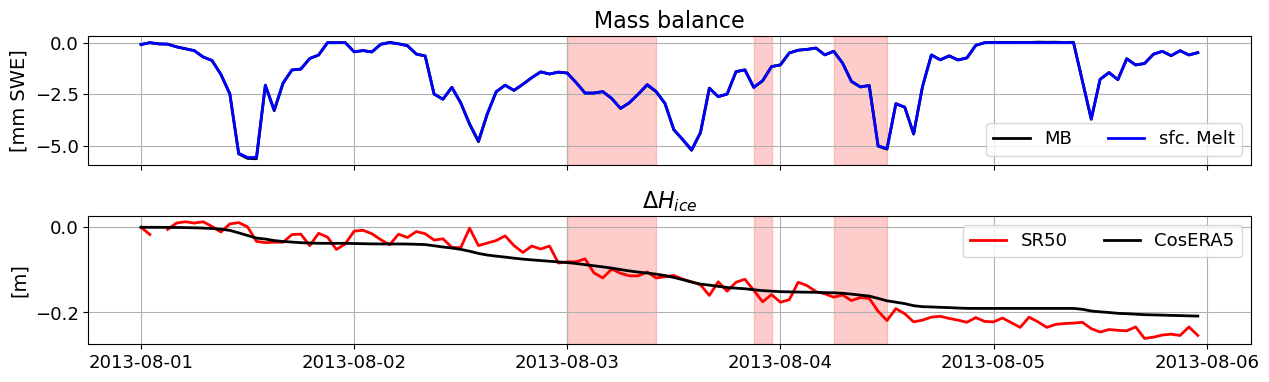

In [15]:
start = pd.to_datetime("2013-08-01 08:00:00")
end = pd.to_datetime("2013-08-06 07:00:00")
cos_massterms_plot(start, end, cosipy_era5, "era5", "case_study_08_2013")

array(-0.00041919)

### Albedo and Snow height
ALbedo and snow height from case study event - use cosipy-ERA5 data

In [101]:
cosipy_era5["Datetime"].sel(Datetime=slice(pd.to_datetime("2013-08-01 08:00:00")-pd.DateOffset(hours = 8), pd.to_datetime("2013-08-06 07:00:00")- pd.DateOffset(hours = 8)))

<xarray.DataArray 'Datetime' (Datetime: 120)>
array(['2013-08-01T00:00:00.000000000', '2013-08-01T01:00:00.000000000',
       '2013-08-01T02:00:00.000000000', '2013-08-01T03:00:00.000000000',
       '2013-08-01T04:00:00.000000000', '2013-08-01T05:00:00.000000000',
       '2013-08-01T06:00:00.000000000', '2013-08-01T07:00:00.000000000',
       '2013-08-01T08:00:00.000000000', '2013-08-01T09:00:00.000000000',
       '2013-08-01T10:00:00.000000000', '2013-08-01T11:00:00.000000000',
       '2013-08-01T12:00:00.000000000', '2013-08-01T13:00:00.000000000',
       '2013-08-01T14:00:00.000000000', '2013-08-01T15:00:00.000000000',
       '2013-08-01T16:00:00.000000000', '2013-08-01T17:00:00.000000000',
       '2013-08-01T18:00:00.000000000', '2013-08-01T19:00:00.000000000',
       '2013-08-01T20:00:00.000000000', '2013-08-01T21:00:00.000000000',
       '2013-08-01T22:00:00.000000000', '2013-08-01T23:00:00.000000000',
       '2013-08-02T00:00:00.000000000', '2013-08-02T01:00:00.000000000',
       '2013-08-02T02:00:00.000000000', '2013-08-02T03:00:00.000000000',
       '2013-08-02T04:00:00.000000000', '2013-08-02T05:00:00.000000000',
       '2013-08-02T06:00:00.000000000', '2013-08-02T07:00:00.000000000',
       '2013-08-02T08:00:00.000000000', '2013-08-02T09:00:00.000000000',
       '2013-08-02T10:00:00.000000000', '2013-08-02T11:00:00.000000000',
       '2013-08-02T12:00:00.000000000', '2013-08-02T13:00:00.000000000',
       '2013-08-02T14:00:00.000000000', '2013-08-02T15:00:00.000000000',
       '2013-08-02T16:00:00.000000000', '2013-08-02T17:00:00.000000000',
       '2013-08-02T18:00:00.000000000', '2013-08-02T19:00:00.000000000',
       '2013-08-02T20:00:00.000000000', '2013-08-02T21:00:00.000000000',
       '2013-08-02T22:00:00.000000000', '2013-08-02T23:00:00.000000000',
       '2013-08-03T00:00:00.000000000', '2013-08-03T01:00:00.000000000',
       '2013-08-03T02:00:00.000000000', '2013-08-03T03:00:00.000000000',
       '2013-08-03T04:00:00.000000000', '2013-08-03T05:00:00.000000000',
       '2013-08-03T06:00:00.000000000', '2013-08-03T07:00:00.000000000',
       '2013-08-03T08:00:00.000000000', '2013-08-03T09:00:00.000000000',
       '2013-08-03T10:00:00.000000000', '2013-08-03T11:00:00.000000000',
       '2013-08-03T12:00:00.000000000', '2013-08-03T13:00:00.000000000',
       '2013-08-03T14:00:00.000000000', '2013-08-03T15:00:00.000000000',
       '2013-08-03T16:00:00.000000000', '2013-08-03T17:00:00.000000000',
       '2013-08-03T18:00:00.000000000', '2013-08-03T19:00:00.000000000',
       '2013-08-03T20:00:00.000000000', '2013-08-03T21:00:00.000000000',
       '2013-08-03T22:00:00.000000000', '2013-08-03T23:00:00.000000000',
       '2013-08-04T00:00:00.000000000', '2013-08-04T01:00:00.000000000',
       '2013-08-04T02:00:00.000000000', '2013-08-04T03:00:00.000000000',
       '2013-08-04T04:00:00.000000000', '2013-08-04T05:00:00.000000000',
       '2013-08-04T06:00:00.000000000', '2013-08-04T07:00:00.000000000',
       '2013-08-04T08:00:00.000000000', '2013-08-04T09:00:00.000000000',
       '2013-08-04T10:00:00.000000000', '2013-08-04T11:00:00.000000000',
       '2013-08-04T12:00:00.000000000', '2013-08-04T13:00:00.000000000',
       '2013-08-04T14:00:00.000000000', '2013-08-04T15:00:00.000000000',
       '2013-08-04T16:00:00.000000000', '2013-08-04T17:00:00.000000000',
       '2013-08-04T18:00:00.000000000', '2013-08-04T19:00:00.000000000',
       '2013-08-04T20:00:00.000000000', '2013-08-04T21:00:00.000000000',
       '2013-08-04T22:00:00.000000000', '2013-08-04T23:00:00.000000000',
       '2013-08-05T00:00:00.000000000', '2013-08-05T01:00:00.000000000',
       '2013-08-05T02:00:00.000000000', '2013-08-05T03:00:00.000000000',
       '2013-08-05T04:00:00.000000000', '2013-08-05T05:00:00.000000000',
       '2013-08-05T06:00:00.000000000', '2013-08-05T07:00:00.000000000',
       '2013-08-05T08:00:00.000000000', '2013-08-05T09:00:00.000000000',
       '2013-08-05T10:00:00.000000000', '2013-08-05T11:00:00.000000000',
       '2013

In [114]:
pd.to_datetime(data_plot["Datetime"])

DatetimeIndex(['2013-07-31 16:00:00', '2013-07-31 17:00:00',
               '2013-07-31 18:00:00', '2013-07-31 19:00:00',
               '2013-07-31 20:00:00', '2013-07-31 21:00:00',
               '2013-07-31 22:00:00', '2013-07-31 23:00:00',
               '2013-08-01 00:00:00', '2013-08-01 01:00:00',
               ...
               '2013-08-05 06:00:00', '2013-08-05 07:00:00',
               '2013-08-05 08:00:00', '2013-08-05 09:00:00',
               '2013-08-05 10:00:00', '2013-08-05 11:00:00',
               '2013-08-05 12:00:00', '2013-08-05 13:00:00',
               '2013-08-05 14:00:00', '2013-08-05 15:00:00'],
              dtype='datetime64[ns]', length=120, freq=None)

In [87]:
jjmc[start_local:end_local]["daily_albedo"].mean()

NameError: name 'start_local' is not defined

ConversionError: Failed to convert value(s) to axis units: [Timestamp('2013-08-03 01:00:00'), Timestamp('2013-08-03 12:00:00')]

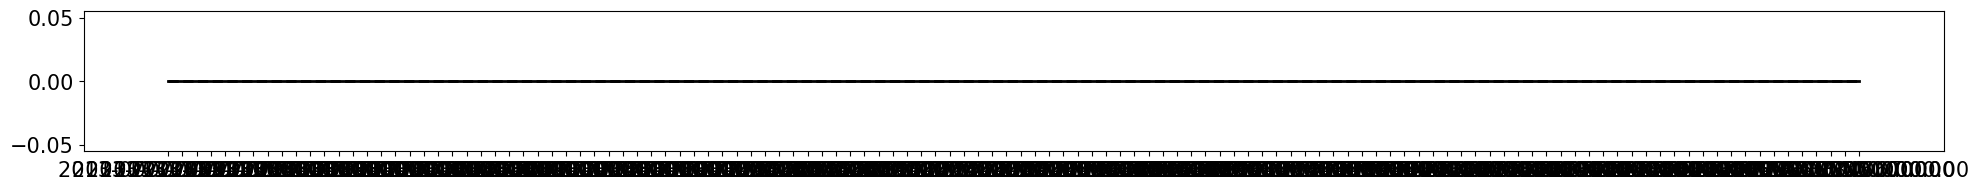

In [23]:
#label and tick font
plt.rcParams['axes.labelsize'] = 15  # fontsize of the x and y labels
plt.rcParams['xtick.labelsize'] = 15  # fontsize of the x ticks
plt.rcParams['ytick.labelsize'] = 15  # fontsize of the y ticks
plt.rcParams['legend.fontsize'] = 12  # fontsize of the legend
plt.rcParams['axes.titlesize'] = 16   # fontsize of the subplot titles

start = pd.to_datetime("2013-08-01 00:00:00")
end = pd.to_datetime("2013-08-05 23:00:00")   

start_local = pd.to_datetime("2013-07-31 16:00:00")
end_local = pd.to_datetime("2013-08-05 15:00:00")

data_plot = cosipy_era5.sel(Datetime=slice(start_local, end_local), time = slice(start, end)).copy()

x1, x2, x3, x4, x5, x6 = [pd.to_datetime("2013-08-03 01:00:00"), pd.to_datetime("2013-08-03 12:00:00"), pd.to_datetime("2013-08-03 21:00:00"),
                          pd.to_datetime("2013-08-03 23:00:00"), pd.to_datetime("2013-08-04 06:00:00"), pd.to_datetime("2013-08-04 12:00:00")]
#Snow height
#SR50_data = (firn[start:end]["SR50 (cor)"] - firn[start:end]["SR50 (cor)"][0]) * (-1)

fig = plt.figure(figsize = (24,4))
ax = fig.add_subplot(2,1,1)
ax.plot(jjmc["Datetime"][start_local:end_local], jjmc["snow_height"][start_local:end_local], color = "k", linewidth = 2, label =  "JJMC obs.")
ax.plot(jjmc["Datetime"][start_local:end_local], data_plot["SNOWHEIGHT"], 
        color = "k", linestyle = "dashed", linewidth = 2, label = "Cosipy")
#mark foehn periods
axvspan_args = {'alpha': 0.2, 'color': 'red'}
ax.axvspan(x1, x2, **axvspan_args); ax.axvspan(x3, x4, **axvspan_args); ax.axvspan(x5, x6, **axvspan_args)
ax.set_ylabel(r"[m]")
ax.set_title("Snow height")
#ax.set_yticks([-0.15, -0.1, -0.05, 0]); 
ax.set_xticklabels([])
ax.grid()

#Albedo
ax = fig.add_subplot(2,1,2)
ax.plot(jjmc["Datetime"][start_local:end_local], jjmc[start_local:end_local]["daily_albedo"], color = "k", linewidth = 2, label = "JJMC obs.")
ax.plot(jjmc["Datetime"][start_local:end_local], data_plot["ALBEDO"].values,
        color = "k", linestyle = "dashed", linewidth = 2, label = "Cosipy")
ax.axvspan(x1, x2, **axvspan_args); ax.axvspan(x3, x4, **axvspan_args); ax.axvspan(x5, x6, **axvspan_args)
ax.set_title("Albedo")
ax.set_ylabel("")
ax.grid()
#ax.set_xticklabels([])
#ax.set_ylim(0,10); ax.set_yticks([0, 2.5, 5, 7.5, 10])


plt.subplots_adjust(hspace=0.4)

#plt.savefig(fr"C:\Users\leopo\Master\Thesis\images\foehn\case_studies\JJMC_{(str(start))[0:10]}_{(str(end))[0:10]}_albedo.pdf", bbox_inches="tight")
#plt.close()
plt.show()

### overall comparison Foehn vs no Foehn in summer
- compare mean energy fluxes
- compare (monthly) mean temperatures
- Foehn frequency
-(only when FM1 available!)

In [28]:
#monthly foehn frequencies:
for m in np.arange(1, 13):
    mon_data = foehn_data.loc[foehn_data.index.month == m]
    
    foehn_freq = len(mon_data.loc[mon_data["prob_jjmc_filter1"] >= 0.5]) / len(mon_data.dropna(subset = "prob_jjmc_filter1"))
    print(f"Month: {m}, Foehn freq = {foehn_freq}") 

Month: 1, Foehn freq = 0.1826163301141352
Month: 2, Foehn freq = 0.08664259927797834
Month: 3, Foehn freq = 0.034055727554179564
Month: 4, Foehn freq = 0.05504587155963303
Month: 5, Foehn freq = 0.06844014510278114
Month: 6, Foehn freq = 0.03737864077669903
Month: 7, Foehn freq = 0.029925187032418952
Month: 8, Foehn freq = 0.03141126318151223
Month: 9, Foehn freq = 0.053282987203692046
Month: 10, Foehn freq = 0.03905447070914697
Month: 11, Foehn freq = 0.04492966617677934
Month: 12, Foehn freq = 0.07546659453611036


In [24]:
foehn_summer = foehn_data.loc[(foehn_data.index.month >= 5) & (foehn_data.index.month <= 9)].copy()
jjmc_summer = jjmc.loc[(jjmc.index.month >= 5) & (jjmc.index.month <= 9)].copy()

In [29]:
foehn_summer_FM1 = foehn_summer.loc[foehn_summer["prob_jjmc_filter1"] >= 0.0].copy()
#frequency during summer
foehn_summer_foehn = foehn_summer_FM1.loc[foehn_summer_FM1["prob_jjmc_filter1"] >= 0.5].copy()
foehn_summer_nofoehn = foehn_summer_FM1.loc[foehn_summer_FM1["prob_jjmc_filter1"] < 0.5].copy()

#jjmc foehn
#jjmc_summer_foehn = jjmc_summer.loc[foehn_summer_FM1["prob_jjmc_filter1"] >= 0.5].copy()
#jjmc_summer_nofoehn = jjmc_summer_FM1.loc[foehn_summer_FM1["prob_jjmc_filter1"] < 0.5].copy()

freq_summer = len(foehn_summer_foehn) / len(foehn_summer_FM1)

In [30]:
freq_summer

0.044255200335055145

In [31]:
foehn_winter = foehn_data.loc[(foehn_data.index.month < 5) | ((foehn_data.index.month >= 9) & (foehn_data.index.month <= 12))].copy()

foehn_winter_FM1 = foehn_winter.loc[foehn_winter["prob_jjmc_filter1"] >= 0.0].copy()
#frequency during winter
foehn_winter_foehn = foehn_winter_FM1.loc[foehn_winter_FM1["prob_jjmc_filter1"] >= 0.5].copy()
foehn_winter_nofoehn = foehn_winter_FM1.loc[foehn_winter_FM1["prob_jjmc_filter1"] < 0.5].copy()
freq_winter = len(foehn_winter_foehn) / len(foehn_winter_FM1)
freq_winter

0.057879613389558535

### Averages
#### monthly mean temperatures

In [21]:
#monthly mean T during Foehn
monmeanT_foehn = foehn_summer_foehn["2m_T_jjmc"].groupby(foehn_summer_foehn.index.month).mean()
#monthly mean T during no foehn
monmeanT_nofoehn = foehn_summer_nofoehn["2m_T_jjmc"].groupby(foehn_summer_nofoehn.index.month).mean()

#### extreme temperature
- percentile?

In [298]:
cosipy_36hmean

<xarray.Dataset>
Dimensions:                  (time: 23111, layer: 200, Datetime: 23111)
Coordinates:
  * time                     (time) datetime64[ns] 2008-08-17T01:00:00 ... 20...
    lat                      float64 69.3
    lon                      float64 -143.8
  * Datetime                 (Datetime) datetime64[ns] 2008-08-16T17:00:00 .....
Dimensions without coordinates: layer
Data variables: (12/49)
    HGT                      (time) float64 dask.array<chunksize=(1079,), meta=np.ndarray>
    MASK                     (time) int32 dask.array<chunksize=(1079,), meta=np.ndarray>
    SLOPE                    (time) int32 dask.array<chunksize=(1079,), meta=np.ndarray>
    ASPECT                   (time) int32 dask.array<chunksize=(1079,), meta=np.ndarray>
    T2                       (time) float64 dask.array<chunksize=(1079,), meta=np.ndarray>
    RH2                      (time) float64 dask.array<chunksize=(1079,), meta=np.ndarray>
    ...                       ...
    LAYER_CC                 (time, layer) float64 dask.array<chunksize=(1079, 200), meta=np.ndarray>
    LAYER_POROSITY           (time, layer) float64 dask.array<chunksize=(1079, 200), meta=np.ndarray>
    LAYER_ICE_FRACTION       (time, layer) float64 dask.array<chunksize=(1079, 200), meta=np.ndarray>
    LAYER_IRREDUCIBLE_WATER  (time, layer) float64 dask.array<chunksize=(1079, 200), meta=np.ndarray>
    LAYER_REFREEZE           (time, layer) float64 dask.array<chunksize=(1079, 200), meta=np.ndarray>
    G_out                    (time) float64 dask.array<chunksize=(1079,), meta=np.ndarray>
Attributes: (12/63)
    Start_from_restart_file:                    False
    Stake_evaluation:                           False
    WRF_simulation:                             False
    Compression_level:                          2
    Slurm_use:                                  False
    Full_fiels:                                 True
    ...                                         ...
    water_density:                              1000.0
    ice_density:                                917.0
    air_density:                                1.1
    sigma:                                      5.67e-08
    zero_temperature:                           273.16
    Surface_emission_coeff:                     0.99

In [96]:
percentiles = []
for perc in np.arange(0, 100):
    percentiles.append(np.percentile(foehn_summer_FM1["2m_T_jjmc"].values, perc))
    

In [98]:
foehn_freq = []
for i,perc in enumerate(percentiles):
    n_obs = len(foehn_summer_FM1.loc[foehn_summer_FM1["2m_T_jjmc"] >= perc])
    n_obs_foehn = len(foehn_summer_FM1.loc[(foehn_summer_FM1["2m_T_jjmc"] >= perc) & 
                                           (foehn_summer_FM1["prob_jjmc_filter1"] >= 0.5)])
    
    foehn_freq.append(n_obs_foehn/n_obs)
    print(f"{0+i} percentile, {perc}: Foehn freq = {n_obs_foehn/n_obs * 100} percent")  

0 percentile, -26.88: Foehn freq = 4.37898459677044 percent
1 percentile, -16.2212: Foehn freq = 4.418539061765536 percent
2 percentile, -14.6424: Foehn freq = 4.416164110356617 percent
3 percentile, -13.2936: Foehn freq = 4.45212051429668 percent
4 percentile, -12.17: Foehn freq = 4.468786351298953 percent
5 percentile, -11.381999999999998: Foehn freq = 4.4920152836288825 percent
6 percentile, -10.727200000000002: Foehn freq = 4.529927224120006 percent
7 percentile, -10.08: Foehn freq = 4.568197738416892 percent
8 percentile, -9.52: Foehn freq = 4.592817400101163 percent
9 percentile, -9.070800000000002: Foehn freq = 4.622858603937612 percent
10 percentile, -8.68: Foehn freq = 4.652364952184026 percent
11 percentile, -8.31: Foehn freq = 4.683253188375497 percent
12 percentile, -7.89: Foehn freq = 4.648088414150495 percent
13 percentile, -7.43: Foehn freq = 4.658252219488715 percent
14 percentile, -6.93572: Foehn freq = 4.648268398268398 percent
15 percentile, -6.465400000000001: Foehn

### energy fluxes/Balance
comparison of the energy fluxes, the surface energy balance and the mass balance between foehn and no foehn periods.

1. energy fluxes: compare the averages of the different fluxes (+compare monthly averages?), compare all cosipy models!

In [32]:
energy_fluxes = ["G", "G_out", "LWin", "LWout", "H", "LE", "B", "Q", "ME", "ALBEDO", "T2", "SNOWHEIGHT"]

In [33]:
#only energy fluxes and convert to dataframe
cosipy_36hmean_Eflux = cosipy_36hmean[energy_fluxes].copy().to_dataframe()
cosipy_108hmean_Eflux = cosipy_108hmean[energy_fluxes].copy().to_dataframe()
cosipy_era5_Eflux = cosipy_era5[energy_fluxes].copy().to_dataframe()

#add net SW and LW radiation
cosipy_36hmean_Eflux["SW_net"] = cosipy_36hmean_Eflux["G"] + cosipy_36hmean_Eflux["G_out"]
cosipy_36hmean_Eflux["LW_net"] = cosipy_36hmean_Eflux["LWin"] + cosipy_36hmean_Eflux["LWout"]
cosipy_108hmean_Eflux["SW_net"] = cosipy_108hmean_Eflux["G"] + cosipy_108hmean_Eflux["G_out"]
cosipy_108hmean_Eflux["LW_net"] = cosipy_108hmean_Eflux["LWin"] + cosipy_108hmean_Eflux["LWout"]
cosipy_era5_Eflux["SW_net"] = cosipy_era5_Eflux["G"] + cosipy_era5_Eflux["G_out"]
cosipy_era5_Eflux["LW_net"] = cosipy_era5_Eflux["LWin"] + cosipy_era5_Eflux["LWout"]

#add foehn probability
ind = foehn_data.index.intersection(cosipy_36hmean_Eflux.index)
cosipy_36hmean_Eflux["prob_jjmc_filter1"] = foehn_data["prob_jjmc_filter1"].loc[ind]
cosipy_108hmean_Eflux["prob_jjmc_filter1"] = foehn_data["prob_jjmc_filter1"].loc[ind]
cosipy_era5_Eflux["prob_jjmc_filter1"] = foehn_data["prob_jjmc_filter1"].loc[ind]

#drop columns when foehn classification is not available
cosipy_36hmean_Eflux = cosipy_36hmean_Eflux.dropna(subset = ["prob_jjmc_filter1"])
cosipy_108hmean_Eflux = cosipy_108hmean_Eflux.dropna(subset = ["prob_jjmc_filter1"])
cosipy_era5_Eflux = cosipy_era5_Eflux.dropna(subset = ["prob_jjmc_filter1"])

In [34]:
#only year 2009 upwards
#cosipy_era5_Eflux = cosipy_era5_Eflux.loc[cosipy_era5_Eflux.index.year > 2009]


### CosERA5 Albedo and snowheight
Explore why Albedo by Era5 cosipy model is only 27% of all time <= 0.2 (const. ice Albedo), but snowheight = 0 during 33%

In [35]:
#len(cosipy_era5_Eflux.loc[cosipy_era5_Eflux["ALBEDO"] <= 0.201]) / len(cosipy_era5_Eflux)
len(cosipy_era5_Eflux.loc[cosipy_era5_Eflux["SNOWHEIGHT"] <= 0.0]) / len(cosipy_era5_Eflux)


0.33421750663129973

In [36]:
test = cosipy_era5_Eflux["SNOWHEIGHT"].loc[cosipy_era5_Eflux["SNOWHEIGHT"] >= 0.00001] * 1
test.nsmallest(20)

time
2010-08-26 15:00:00    0.000010
2012-07-18 15:00:00    0.000011
2008-09-09 12:00:00    0.000012
2008-09-09 05:00:00    0.000012
2010-08-26 16:00:00    0.000013
2008-09-10 00:00:00    0.000014
2008-09-09 06:00:00    0.000014
2008-09-09 07:00:00    0.000015
2008-08-23 12:00:00    0.000015
2008-08-23 11:00:00    0.000015
2008-08-23 10:00:00    0.000015
2008-09-09 09:00:00    0.000015
2008-09-09 08:00:00    0.000015
2008-08-23 13:00:00    0.000015
2010-09-20 01:00:00    0.000015
2008-08-23 14:00:00    0.000016
2008-09-09 10:00:00    0.000016
2014-07-30 05:00:00    0.000016
2010-06-24 14:00:00    0.000016
2008-09-09 16:00:00    0.000016
Name: SNOWHEIGHT, dtype: float64

In [37]:
#split in foehn and no foehn
#era5
ERA5_foehn = cosipy_era5_Eflux.loc[cosipy_era5_Eflux["prob_jjmc_filter1"] >= 0.5].copy()
ERA5_nofoehn = cosipy_era5_Eflux.loc[cosipy_era5_Eflux["prob_jjmc_filter1"] < 0.5].copy()
#108hmean
C108_foehn = cosipy_108hmean_Eflux.loc[cosipy_108hmean_Eflux["prob_jjmc_filter1"] >= 0.5].copy()
C108_nofoehn = cosipy_108hmean_Eflux.loc[cosipy_108hmean_Eflux["prob_jjmc_filter1"] < 0.5].copy()
#36hmean
C36_foehn = cosipy_36hmean_Eflux.loc[cosipy_36hmean_Eflux["prob_jjmc_filter1"] >= 0.5].copy()
C36_nofoehn = cosipy_36hmean_Eflux.loc[cosipy_36hmean_Eflux["prob_jjmc_filter1"] < 0.5].copy()

#total difference
ERA5_totdiff = ERA5_foehn.mean() - ERA5_nofoehn.mean()


In [18]:
len(ERA5_foehn_ice)

NameError: name 'ERA5_foehn_ice' is not defined

In [38]:
 ERA5_totdiff

G                   -2.454004e+01
G_out               -2.783423e+00
LWin                -3.180821e+00
LWout               -1.916667e+00
H                    3.338127e+01
LE                  -8.305372e+00
B                   -3.019757e+00
Q                   -1.469020e-04
ME                  -5.771127e+00
ALBEDO               1.167992e-01
T2                   1.849159e+00
SNOWHEIGHT           8.963357e-02
lat                 -2.518163e-11
lon                 -3.214495e-11
SW_net              -2.732346e+01
LW_net              -5.097488e+00
prob_jjmc_filter1    8.602464e-01
dtype: float64

In [39]:
#compute monthly averages
#era5
ERA5_foehn_monmean = ERA5_foehn.groupby(ERA5_foehn.index.month).mean()
ERA5_nofoehn_monmean = ERA5_nofoehn.groupby(ERA5_nofoehn.index.month).mean()
#108hmean
C108_foehn_monmean = C108_foehn.groupby(C108_foehn.index.month).mean()
C108_nofoehn_monmean = C108_nofoehn.groupby(C108_nofoehn.index.month).mean()
#36hmean
C36_foehn_monmean = C36_foehn.groupby(C36_foehn.index.month).mean()
C36_nofoehn_monmean = C36_nofoehn.groupby(C36_nofoehn.index.month).mean()

#differences of the monthly means
#era5 
ERA5_diff = ERA5_foehn_monmean.copy() - ERA5_nofoehn_monmean.copy()
C108_diff = C108_foehn_monmean.copy() - C108_nofoehn_monmean.copy()
C36_diff = C36_foehn_monmean.copy() - C36_nofoehn_monmean.copy()

In [187]:
ERA5_foehn_monmean

,G,G_out,LWin,LWout,H,LE,B,Q,ME,ALBEDO,T2,SNOWHEIGHT,lat,lon,SW_net,LW_net,prob_jjmc_filter1
time,,,,,,,,,,,,,,,,,
5,205.743942,-172.459531,241.378173,-284.673132,37.732673,-13.442291,-4.304252,0.000000,6.704133,0.838025,271.982982,0.487688,69.3,-143.8,33.284410,-43.294959,0.868051
6,170.468393,-135.732858,269.316699,-306.815685,49.529034,-13.652320,3.730288,0.000286,33.534864,0.780304,277.855742,0.491990,69.3,-143.8,34.735535,-37.498986,0.863596
7,149.171013,-54.776199,299.576955,-311.784325,64.613265,4.369869,-8.576722,0.001418,126.756902,0.334229,279.735664,0.042548,69.3,-143.8,94.394815,-12.207369,0.815903
8,69.249176,-19.013020,288.893419,-308.144880,69.230921,7.131428,-9.213884,0.000975,90.139442,0.355207,279.246348,0.025061,69.3,-143.8,50.236156,-19.251461,0.839605
9,53.996089,-42.674948,260.027563,-288.265376,38.274003,-12.095115,-0.557061,0.000024,7.618846,0.792755,273.031276,0.140260,69.3,-143.8,11.321140,-28.237813,0.908924


In [40]:
#differences of ice vs no ice
#ice
ERA5_foehn_ice = ERA5_foehn.loc[ERA5_foehn["ALBEDO"] <= 0.2]
ERA5_nofoehn_ice =  ERA5_nofoehn.loc[ERA5_nofoehn["ALBEDO"] <= 0.2]
ERA5_ice_diff = ERA5_foehn_ice.mean() - ERA5_nofoehn_ice.mean()
#snow
ERA5_foehn_snow = ERA5_foehn.loc[ERA5_foehn["ALBEDO"] > 0.2]
ERA5_nofoehn_snow =  ERA5_nofoehn.loc[ERA5_nofoehn["ALBEDO"] > 0.2]
ERA5_snow_diff = ERA5_foehn_snow.mean() - ERA5_nofoehn_snow.mean()

In [41]:
#cosipy_era5_Eflux["ME"].loc[cosipy_era5_Eflux["SNOWHEIGHT"] <= 0].mean()
cosipy_era5_Eflux["ME"].loc[cosipy_era5_Eflux["SNOWHEIGHT"] <= 0].mean()

104.65235251598536

In [42]:
ERA5_foehn_ice["ME"].mean()

151.5668855452284

In [43]:
ERA5_nofoehn_ice["ME"].mean()

100.12226852761103

In [51]:
#frequency of FOehn during ice and snow
freq_ice = len(ERA5_foehn_ice) / len(cosipy_era5_Eflux.loc[cosipy_era5_Eflux["ALBEDO"] <= 0.2])
freq_snow = len(ERA5_foehn_snow) / len(cosipy_era5_Eflux.loc[cosipy_era5_Eflux["ALBEDO"] > 0.2])
ERA5_snow_diff["foehn_freq"] = freq_snow
ERA5_ice_diff["foehn_freq"] = freq_ice
print("ice: ", freq_ice)
print("snow: ", freq_snow)

ice:  0.025430960914831883
snow:  0.051311580294305825


In [111]:
cosipy_era5_Eflux

,G,G_out,LWin,LWout,H,LE,B,Q,ME,ALBEDO,T2,lat,lon,SW_net,LW_net,prob_jjmc_filter1
time,,,,,,,,,,,,,,,,
2008-08-17 01:00:00,195.431176,-39.086235,307.426636,-312.526371,0.464536,0.219721,0.000000,0.001452,1.206934e+02,0.200000,276.850,69.3,-143.8,156.344941,-5.099735,0.0
2008-08-17 02:00:00,143.049893,-28.609979,309.452906,-312.526371,3.427336,1.939156,0.000000,0.001210,9.394982e+01,0.200000,275.964,69.3,-143.8,114.439914,-3.073466,0.0
2008-08-17 03:00:00,97.979378,-19.595876,315.165018,-312.526371,5.452263,1.992083,0.000000,0.000918,7.281819e+01,0.200000,275.477,69.3,-143.8,78.383503,2.638647,0.0
2008-08-17 04:00:00,76.800759,-15.360152,289.053368,-312.526371,4.645780,2.066211,0.000000,0.000447,3.239414e+01,0.200000,275.630,69.3,-143.8,61.440607,-23.473004,0.0
2008-08-17 05:00:00,40.774495,-8.154899,307.699597,-312.526371,1.835959,0.810101,0.000000,0.000307,2.391496e+01,0.200000,275.360,69.3,-143.8,32.619596,-4.826775,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-09-30 19:00:00,145.386324,-123.555520,261.381035,-272.420443,4.605629,-8.641193,-4.572221,0.000000,5.305297e-04,0.849843,265.020,69.3,-143.8,21.830804,-11.039408,0.0
2014-09-30 20:00:00,181.186481,-153.980027,254.439438,-272.166440,5.164547,-8.941322,-2.982668,0.000000,0.000000e+00,0.849843,264.940,69.3,-143.8,27.206454,-17.727002,0.0
2014-09-30 21:00:00,199.877932,-169.864773,257.620569,-273.770206,4.874332,-12.419222,-3.317347,0.000000,1.382058e-05,0.849843,265.060,69.3,-143.8,30.013159,-16.149637,0.0


In [45]:
#how often snow free?
len(cosipy_era5_Eflux.loc[cosipy_era5_Eflux["ALBEDO"] <= 0.2]) / len(cosipy_era5_Eflux)
#len(cosipy_era5_Eflux.loc[cosipy_era5_Eflux["SNOWHEIGHT"] == 0]) / len(cosipy_era5_Eflux)

0.27265112383079715

In [46]:
len(cosipy_era5_Eflux.loc[cosipy_era5_Eflux["ALBEDO"] > 0.2]) / len(cosipy_era5_Eflux)

0.7273488761692029

In [47]:
len(jjmc_summer.loc[jjmc_summer["snow_height"] == 0]) / len(jjmc_summer)

0.295486997533642

In [52]:
ERA5_foehn["local_time"] = ERA5_foehn.index - pd.DateOffset(hours=8)
ERA5_foehn_local = ERA5_foehn.copy()
ERA5_foehn_local.set_index("local_time", inplace = True)

ERA5_nofoehn["local_time"] = ERA5_nofoehn.index - pd.DateOffset(hours=8)
ERA5_nofoehn_local = ERA5_nofoehn.copy()
ERA5_nofoehn_local.set_index("local_time", inplace = True)

In [53]:
#Why SW smaller during Foehn? Daytime?
hourly_foehn = ERA5_foehn_local.index.hour.value_counts().sort_index()

In [54]:
foehn_hourly_means = ERA5_foehn_local[["SW_net", "LW_net", "H", "LE", "B", "ME"]].groupby(ERA5_foehn_local.index.hour).mean()
nofoehn_hourly_means = ERA5_nofoehn_local[["SW_net", "LW_net", "H", "LE", "B", "ME"]].groupby(ERA5_nofoehn_local.index.hour).mean()
hourly_means_diff = foehn_hourly_means - nofoehn_hourly_means

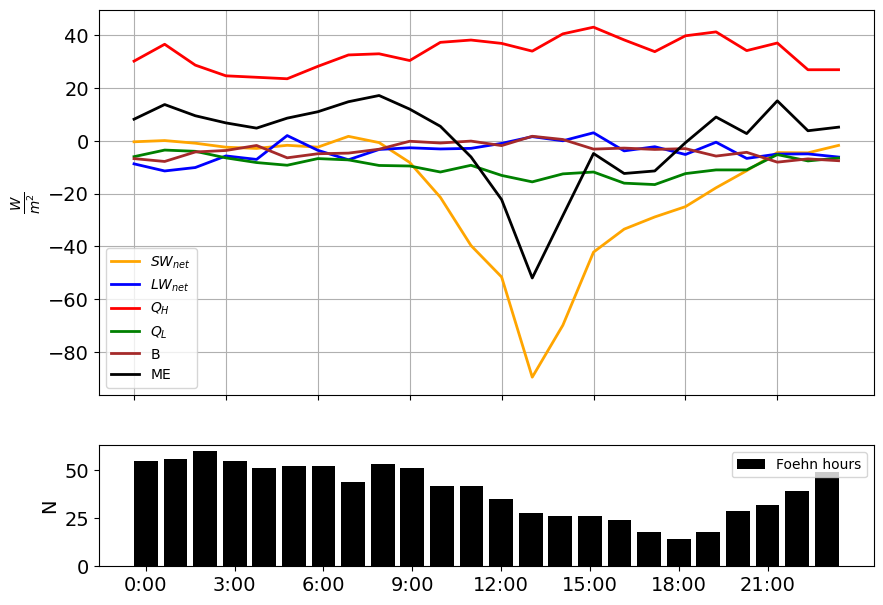

In [55]:
#daytime plot ERA5 hours
plt.rcParams['axes.labelsize'] = 14  # fontsize of the x and y labels
plt.rcParams['xtick.labelsize'] = 14  # fontsize of the x ticks
plt.rcParams['ytick.labelsize'] = 14  # fontsize of the y ticks
plt.rcParams['legend.fontsize'] = 10  # fontsize of the legend
plt.rcParams['axes.titlesize'] = 15   # fontsize of the subplot titles

#monmean_nofoehn[fluxes].plot(ax = ax, kind="bar", stacked=True, title="Monthly energy fluxes during no-foehn, 2008-2014")
#ax.plot(np.arange(0, 12), monmean_nofoehn["ME"], label = "ME", color = "k", linewidth = 3)
width=0.25
shift = width/2
xticks=np.arange(0,24)
variables = ["SW_net", "LW_net", "H", "LE", "B", "ME"]
colors = ["orange", "b","r", "green", "brown", "k"]
labels = ["$SW_{net}$", "$LW_{net}$", "$Q_H$", "$Q_L$", "B", "ME"]

fig =  plt.figure(figsize = (10, 11))
ax = fig.add_subplot(2,1,1)
for var, col, lab in zip(variables, colors, labels):
    ax.plot(xticks, hourly_means_diff[var], color = col, label = lab, linewidth = 2) 
ax.legend(loc = "lower left") ; ax.set_ylabel(r"$\frac{W}{m^2}$")
ax.grid(); ax.set_xticks(np.arange(0,22,3)); ax.set_xticklabels([])

ax2 = fig.add_subplot(6,1,4)
ax2.bar(xticks, hourly_foehn, color = "k", label = r"Foehn hours")
ax2.legend()
ax2.set_xticks(np.arange(0,22,3)); ax2.set_xticklabels(["0:00", "3:00", "6:00", "9:00", "12:00", "15:00", "18:00", "21:00"])
ax2.set_ylabel("N"); #ax2.set_xlabel("hour of day")

In [56]:
#sum of fluxes = melt energy?
time = "2013-08-03"
print("ME :", cosipy_era5_Eflux[time]["ME"])
print("flux sum :", cosipy_era5_Eflux[time][["Q", "H", "LE", "B", "G", "G_out", "LWin", "LWout"]])

ME : time
2013-08-03 00:00:00    220.281900
2013-08-03 01:00:00    191.181366
2013-08-03 02:00:00    214.460002
2013-08-03 03:00:00    186.982384
2013-08-03 04:00:00    157.265239
2013-08-03 05:00:00    131.257182
2013-08-03 06:00:00    140.730283
2013-08-03 07:00:00    132.285023
2013-08-03 08:00:00    136.490740
2013-08-03 09:00:00    179.452956
2013-08-03 10:00:00    226.500339
2013-08-03 11:00:00    226.490115
2013-08-03 12:00:00    219.920496
2013-08-03 13:00:00    250.776186
2013-08-03 14:00:00    295.635499
2013-08-03 15:00:00    269.745498
2013-08-03 16:00:00    230.614211
2013-08-03 17:00:00    187.781447
2013-08-03 18:00:00    218.757898
2013-08-03 19:00:00    272.646129
2013-08-03 20:00:00    390.906379
2013-08-03 21:00:00    435.056714
2013-08-03 22:00:00    481.748187
2013-08-03 23:00:00    402.902336
Name: ME, dtype: float64
flux sum :                             Q           H         LE          B           G  \
time                                                       

C:\Users\leopo\AppData\Local\Temp\ipykernel_6336\1181742446.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  print("ME :", cosipy_era5_Eflux[time]["ME"])
C:\Users\leopo\AppData\Local\Temp\ipykernel_6336\1181742446.py:4: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  print("flux sum :", cosipy_era5_Eflux[time][["Q", "H", "LE", "B", "G", "G_out", "LWin", "LWout"]])


In [57]:
#EB
plot_params = ["SW_net", "LW_net", "H", "LE", "B", "ME", "T2", "G", "G_out", "LWin", "LWout"]
ERA5_plot = ERA5_diff[plot_params].copy()
ERA5_totdiff_plot = ERA5_totdiff[plot_params].copy()

#C108_plot = C108_diff[plot_params].copy()
#C36_plot = C36_diff[plot_params].copy()

In [101]:
ERA5_diff

,G,G_out,LWin,LWout,H,LE,B,Q,ME,ALBEDO,T2,SNOWHEIGHT,lat,lon,SW_net,LW_net,prob_jjmc_filter1
time,,,,,,,,,,,,,,,,,
5,-10.848787,4.531693,4.410509,-7.293139,24.808465,-10.638443,-6.286630,-0.000023,-0.692553,0.019415,2.595910,0.040133,0.0,0.0,-6.317094,-2.882629,0.860982
6,-48.098461,13.026064,-11.069920,-0.954501,35.605700,-14.629540,2.205035,-0.000264,-17.704853,0.102212,1.403866,0.188753,0.0,0.0,-35.072397,-12.024421,0.861170
7,-17.359626,4.765683,-0.616996,-1.171081,47.521619,-0.924874,-3.204117,0.000180,30.682583,-0.002497,2.164003,0.002486,0.0,0.0,-12.593944,-1.788077,0.805938
8,-58.749374,20.739364,11.177752,-5.151935,54.450540,6.353091,-7.075110,0.000226,27.805383,0.038714,4.213710,0.006810,0.0,0.0,-38.010009,6.025817,0.829330
9,-15.750825,3.408401,11.598071,-12.572334,25.168098,-10.320050,-3.089888,-0.000048,0.417451,0.107454,3.961225,0.015481,0.0,0.0,-12.342424,-0.974263,0.900406


SW_net   -21.823522
LW_net    -2.139707
H         37.143149
LE        -6.194011
B         -3.447283
ME         7.040004
T2         2.819776
G        -31.717447
G_out      9.893925
LWin       3.300832
LWout     -5.440540
dtype: float64

### how many days of data available in the different months?

In [59]:
#ERA5_foehnERA5_no_foehn
mondata_list = []
monfoehndata_list = []
monnofoehndata_list = []
foehn_freq_list = []
for mon in np.arange(5,10):
    monthly_datalength = len(cosipy_era5_Eflux.loc[cosipy_era5_Eflux.index.month == mon])
    monthly_foehndatalength = len(ERA5_foehn.loc[ERA5_foehn.index.month == mon])
    monthly_nofoehndatalength = len(ERA5_nofoehn.loc[ERA5_nofoehn.index.month == mon])
    
    foehn_freq = monthly_foehndatalength / monthly_datalength
    foehn_freq_list.append(foehn_freq)
    
    mondata_list.append(monthly_datalength)
    monfoehndata_list.append(monthly_foehndatalength)
    monnofoehndata_list.append(monthly_nofoehndatalength)
    print(mon, ": ", monthly_datalength, "Foehn: ", monthly_foehndatalength, "no Foehn: ", monthly_nofoehndatalength, "foehn freq: ", foehn_freq)

5 :  4135 Foehn:  283 no Foehn:  3852 foehn freq:  0.06844014510278114
6 :  4120 Foehn:  154 no Foehn:  3966 foehn freq:  0.03737864077669903
7 :  4010 Foehn:  120 no Foehn:  3890 foehn freq:  0.029925187032418952
8 :  4457 Foehn:  140 no Foehn:  4317 foehn freq:  0.03141126318151223
9 :  4767 Foehn:  254 no Foehn:  4513 foehn freq:  0.053282987203692046


In [61]:
ERA5_totdiff["foehn_freq"] = freq_summer *100

In [100]:
ERA5_plot

,SW_net,LW_net,H,LE,B,ME,T2,G,G_out,LWin,LWout,foehn_freq
time,,,,,,,,,,,,
5,-6.392770,-2.731796,24.816834,-10.730494,-6.274867,-0.683557,2.473636,-11.628360,5.235590,4.244984,-6.976780,6.747279
6,-35.252150,-11.792121,35.287920,-14.544727,2.164927,-17.898689,1.394351,-48.837697,13.585547,-10.798847,-0.993274,3.762136
7,-14.749236,-1.666296,46.934765,-1.231081,-3.276952,28.140577,2.117377,-19.785568,5.036332,-0.501889,-1.164407,2.967581
8,-40.270007,6.204966,53.574514,5.944400,-6.879438,25.097985,4.160255,-61.474022,21.204015,11.289923,-5.084957,3.096253
9,-12.453447,-0.713290,25.101712,-10.408155,-2.970086,0.543702,3.953263,-16.861587,4.408141,12.269992,-12.983282,5.244389


[0.06747279322853689,
 0.03762135922330097,
 0.029675810473815463,
 0.030962530850347766,
 0.052443885043003985]

In [62]:
plot_params2 = ["SW_net", "LW_net", "H", "LE", "B", "ME", "T2", "G", "G_out", "LWin", "LWout", "foehn_freq"]
#add foehn frequency
ERA5_plot["foehn_freq"] = foehn_freq_list 
ERA5_plot["foehn_freq"] *= 100
#add total summer average
ERA5_plot.loc[10] = ERA5_totdiff[plot_params2]

#second plot
ERA5_totdiff2 = ERA5_totdiff[plot_params2].copy().to_frame()
ERA5_ice_plot = ERA5_ice_diff[plot_params2].copy().to_frame()
ERA5_snow_plot = ERA5_snow_diff[plot_params2].copy().to_frame()

ERA5_totdiff_plot = pd.concat([ERA5_totdiff2.T, ERA5_ice_plot.T, ERA5_snow_plot.T], axis = 0)
ERA5_totdiff_plot.index = ["Summer", "Ice", "Snow"]

In [63]:
ERA5_totdiff_plot["foehn_freq"][1:3] *= 100

In [64]:
ERA5_totdiff_plot

,SW_net,LW_net,H,LE,B,ME,T2,G,G_out,LWin,LWout,foehn_freq
Summer,-27.323464,-5.097488,33.381270,-8.305372,-3.019757,-5.771127,1.849159,-24.540041,-2.783423,-3.180821,-1.916667,4.425520
Ice,-31.601953,5.381357,70.867545,8.781751,-8.099471,51.444617,3.480328,-39.502442,7.900488,7.189607,-1.808250,2.543096
Snow,-14.870590,-5.975816,27.898275,-10.730176,-3.216348,-5.452294,2.351383,-22.294598,7.424008,-0.924724,-5.051092,5.131158


### sfcEB summer  Foehn vs no FOehn 
##### MONTHLY MEANS OF EB AND FOEHN FREQUENCY

In [100]:
#ME monthly means
ERA5_ME = cosipy_era5_Eflux["ME"].groupby(cosipy_era5_Eflux.index.month).mean()

#label and tick font
plt.rcParams['axes.labelsize'] = 15  # fontsize of the x and y labels
plt.rcParams['xtick.labelsize'] = 15  # fontsize of the x ticks
plt.rcParams['ytick.labelsize'] = 15  # fontsize of the y ticks
plt.rcParams['legend.fontsize'] = 15  # fontsize of the legend
plt.rcParams['axes.titlesize'] = 15   # fontsize of the subplot titles

#monmean_nofoehn[fluxes].plot(ax = ax, kind="bar", stacked=True, title="Monthly energy fluxes during no-foehn, 2008-2014")
#ax.plot(np.arange(0, 12), monmean_nofoehn["ME"], label = "ME", color = "k", linewidth = 3)
width=0.25
shift = width/2
xticks=np.arange(0,5)
fig =  plt.figure(figsize = (10, 6))
ax = fig.add_subplot(1,1,1)
ax2 = ax.twinx()
ERA5_plot[0:5]["foehn_freq"].plot(ax = ax2, kind = "bar", width = width, color = "grey", label = "foehn frequency", zorder = 4)#, alpha = 0.5)
ax.plot(xticks,ERA5_foehn_monmean[0:5]["ME"], color = "r", label = r"$ME_{Foehn}$", linewidth = 2, zorder = 10)
ax.plot(xticks,ERA5_nofoehn_monmean[0:5]["ME"], color = "b", label = r"$ME_{noFoehn}$", linewidth = 2, zorder = 10)
ax.plot(xticks,ERA5_ME, color = "k", label = r"$ME_{all}$", linewidth = 2, zorder = 10)

#reverse ax zorder
ax.set_zorder(ax2.get_zorder() + 1)
ax.patch.set_visible(False)

ax.set_ylabel(r"ME [$\frac{W}{m^2}$]"); ax.set_ylim(0, 140)
ax.set_xticks(xticks)
ax.set_xlabel(""); ax.set_xticklabels([]); #ax.tick_params(bottom=False) 
#ax.set_title(r"available melt energy")

#ax2 = fig.add_subplot(6,1,4)
ax2.set_ylabel(r"$f_{Foehn}$ [%]");#, loc = "bottom"); 

#ax2.legend(loc = "upper left", bbox_to_anchor=[0,1.25], fontsize = 9)
ax2.set_xticks(xticks); ax2.set_xticklabels(["May","Jun","Jul","Aug","Sep"], rotation=0)# "Summer"], rotation=0)
ax2.set_yticks([2,4,6, 8, 10, 12, 14]); ax2.set_yticklabels([" 2", " 4", " 6", "", "", "", ""]); ax2.set_ylim(0, 14)
ax2.set_xlabel(""); #ax2.set_title("Available melt energy and Foehn frequency")

# Handles und Labels von ax2 bekommen
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Kombinieren der Handles und Labels
handles = handles1 + handles2
labels = labels1 + labels2

# Hinzufügen der kombinierten Legende zu ax
ax.legend(handles, labels, loc="upper left")
#ax2.grid(axis = "y", linestyle = "dashed", zorder = 0)

plt.savefig(r"C:\Users\leopo\Master\Thesis\images\jjmc_EB_foehn\overview\ME_foehn_freq_ERA5.pdf", bbox_inches="tight")
plt.close()
#plt.show()

time
5     7.387690
6    51.433553
7    98.616325
8    65.041457
9     7.075144
Name: ME, dtype: float64

time
5     7.341568
6    50.760180
7    99.451419
8    65.818554
9     7.103658
Name: ME, dtype: float64

##### MONTHLY MEANS

In [113]:
#label and tick font
plt.rcParams['axes.labelsize'] = 15  # fontsize of the x and y labels
plt.rcParams['xtick.labelsize'] = 15  # fontsize of the x ticks
plt.rcParams['ytick.labelsize'] = 15  # fontsize of the y ticks
plt.rcParams['legend.fontsize'] = 15  # fontsize of the legend
plt.rcParams['axes.titlesize'] = 15   # fontsize of the subplot titles

#monmean_nofoehn[fluxes].plot(ax = ax, kind="bar", stacked=True, title="Monthly energy fluxes during no-foehn, 2008-2014")
#ax.plot(np.arange(0, 12), monmean_nofoehn["ME"], label = "ME", color = "k", linewidth = 3)
width=0.25
shift = +width/2
xticks=np.arange(0,5)+shift

fig =  plt.figure(figsize = (10, 6))
ax = fig.add_subplot(1,1,1)
#colors = ["orange", "b","r", "green", "brown"]
colors = ["orange", "b","deeppink", "green", "darkviolet"]
labels = ["$SW_{net}$", "$LW_{net}$", "$Q_H$", "$Q_L$", "B"]

#for i, column in enumerate(["SW_net", "LW_net", "H", "LE", "B"]):
#    ax.bar(np.arange(0,5), ERA5_plot[column].values, width=0.3, color=colors[i], label=labels[i])
#ERA5_plot[0:5]["ME"].plot(ax = ax, color = "k", label = r"$\Delta ME$")# kind = "bar", width=width, color = "k", label = "ME", position =1)
ax.plot(xticks, ERA5_plot["ME"][0:5], color = "k", zorder = 5)


ERA5_plot[0:5][["SW_net", "LW_net", "H", "LE", "B"]].plot(ax = ax, kind = "bar", stacked = True, width=width,
                                                    #color = ["#0000FF", "#00FF00", "#FFA500", "#00CED1", "#9400D3"],
                                                    color = ["orange", "cornflowerblue", "firebrick", "green", "rebeccapurple"],
                                                    #color = ["orange", "darkviolet", "b", "green", "deeppink"], 
                                                    label = [r"$\Delta SW_{net}$", r"$\Delta LW_{net}$", r"$\Delta H$", r"$\Delta LE$", r"$\Delta B$"], 
                                                    position = 0, zorder = 3)
#ERA5_plot[0:5]["ME"].plot(ax = ax, color = "k")

#ax.grid(axis = "y", linestyle = "dashed", zorder = 0)

for container in ax.containers:
    for rect in container:
        rect.set_x(rect.get_x())# + shift)

ax.set_ylabel(r"[$\frac{W}{m^2}$]")
ax.legend([r"$\Delta ME$", r"$\Delta SW_{net}$", r"$\Delta LW_{net}$", r"$\Delta H$", r"$\Delta LE$", r"$\Delta B$"], loc="upper left", ncol = 2)
#ax.legend(loc = "upper left", ncol = 2)#, bbox_to_anchor = (1.2, 1.03))
ax.set_xlabel(""); ax.set_xticklabels([]); #ax.tick_params(bottom=False)
ax.set_ylim((-70, 90)); ax.set_xticks(xticks)
ax.set_xticklabels(["May","Jun","Jul","Aug","Sep"], rotation=0)
#ax.set_title(r"$\overline{EB_{foehn}}$ - $\overline{EB_{nofoehn}}$")
#plt.title("surface energy balance, CosERA5")
ax.axhline(0, color = "grey", linewidth=0.5)

#save
plt.savefig(r"C:\Users\leopo\Master\Thesis\images\jjmc_EB_foehn\overview\EB_diff_summer_ERA5.pdf", bbox_inches="tight")
plt.close()
#plt.show()


[<BarContainer object of 5 artists>,
 <BarContainer object of 5 artists>,
 <BarContainer object of 5 artists>,
 <BarContainer object of 5 artists>,
 <BarContainer object of 5 artists>,
 <BarContainer object of 5 artists>]

### SITUATION MEANS

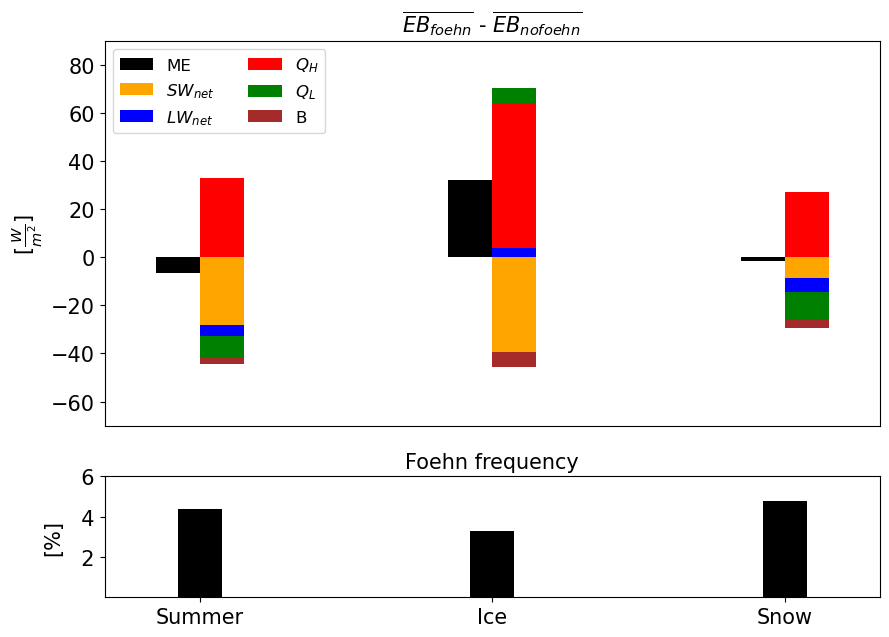

In [224]:
#label and tick font
plt.rcParams['axes.labelsize'] = 15  # fontsize of the x and y labels
plt.rcParams['xtick.labelsize'] = 15  # fontsize of the x ticks
plt.rcParams['ytick.labelsize'] = 15  # fontsize of the y ticks
plt.rcParams['legend.fontsize'] = 12  # fontsize of the legend
plt.rcParams['axes.titlesize'] = 15   # fontsize of the subplot titles

#monmean_nofoehn[fluxes].plot(ax = ax, kind="bar", stacked=True, title="Monthly energy fluxes during no-foehn, 2008-2014")
#ax.plot(np.arange(0, 12), monmean_nofoehn["ME"], label = "ME", color = "k", linewidth = 3)
width=0.15
shift = width/2
xticks=np.arange(0,3)

fig =  plt.figure(figsize = (10, 6))
ax = fig.add_subplot(1,1,1)
colors = ["orange", "b","r", "green", "brown"]
labels = ["$SW_{net}$", "$LW_{net}$", "$Q_H$", "$Q_L$", "B"]

#for i, column in enumerate(["SW_net", "LW_net", "H", "LE", "B"]):
#    ax.bar(np.arange(0,5), ERA5_plot[column].values, width=0.3, color=colors[i], label=labels[i])
ERA5_totdiff_plot["ME"].plot(ax = ax, kind = "bar", width=width, color = "k", label = "ME", position =1)
ERA5_totdiff_plot[["SW_net", "LW_net", "H", "LE", "B"]].plot(ax = ax, kind = "bar", stacked = True, width=width,
                                                    color = ["orange", "b","r", "green", "brown"], 
                                                    label = ["$SW_{net}$", "$LW_{net}$", "H", "LE", "B"], position = 0)

for container in ax.containers:
    for rect in container:
        rect.set_x(rect.get_x() + shift)
#ax.plot(np.arange(0,5), ERA5_plot["ME"], color = "k", linewidth = 3, label = "ME")
#ax2 = ax.twinx()

ax.set_ylabel(r"[$\frac{W}{m^2}$]")
ax.legend(loc = "upper left", ncol = 2)#, bbox_to_anchor = (1.2, 1.03))
ax.set_ylim((-70, 90))
ax.set_xlabel(""); ax.set_xticklabels(["Summer","Ice","Snow"]); #ax.tick_params(bottom=False)
ax.set_xticks(xticks)
ax.set_title(r"$\overline{EB_{foehn}}$ - $\overline{EB_{nofoehn}}$")
#plt.title("surface energy balance, CosERA5")

ax2 = fig.add_subplot(6,1,4)

ERA5_totdiff_plot["foehn_freq"].plot(ax = ax2, kind = "bar", width = width, color = "k", label = "foehn frequency")
#ax2.plot(np.arange(0,5), cosipy_era5_mass_mondiff["MB"], color = "k", linewidth = 3, label = "MB")
ax2.set_ylabel("[%]"); 


# Neues Mapping der Labels
new_labels = {'SW_net': '$SW_{net}$', 'LW_net': '$LW_{net}$', "H":"$Q_H$", "LE":"$Q_L$", "B":"B"}
# Holen Sie sich die aktuellen Handles und Labels
handles, labels = ax.get_legend_handles_labels()
# Ändern Sie die Labels gemäß Ihrem Mapping
renamed_labels = [new_labels[label] if label in new_labels else label for label in labels]

# Setzen Sie die neuen Labels in der Legende
ax.legend(handles, renamed_labels, ncol = 2, loc = "upper left")

#ax2.legend(loc = "upper left", bbox_to_anchor=[0,1.25], fontsize = 9)
ax2.set_xticks(xticks); ax2.set_xticklabels(["Summer","Ice","Snow"], rotation=0)# "Summer"], rotation=0)
ax2.set_yticks([2,4,6]); ax2.set_yticklabels(["  2", "  4", "  6"])
ax2.set_xlabel(""); ax2.set_title("Foehn frequency")
#add vertical separation line
#line_position = xticks[-1] - width - shift / 2
#ax.axvline(line_position, color='gray', linestyle='--')
#ax2.axvline(line_position-shift, color='gray', linestyle='--')

#save
#plt.savefig(r"C:\Users\leopo\Master\Thesis\images\jjmc_EB_foehn\overview\EB_diff_snow_ice_ERA5.pdf", bbox_inches="tight")
#plt.close()
plt.show()

### MB summer Foehn vs no Foehn

In [126]:
mass_terms = ["MB", "surfMB", "intMB", "subM", "surfM", "Q", "REFREEZE", 
                               "EVAPORATION", "CONDENSATION", "SUBLIMATION", "DEPOSITION", "SNOWFALL"]
cosipy_era5_mass = cosipy_era5[mass_terms].to_dataframe().copy()

#convert to mm insteasd of m SWE
cosipy_era5_mass[mass_terms] *= 1000


In [202]:
#add Foehn probability
ind = foehn_data.index.intersection(cosipy_era5_mass.index)
cosipy_era5_mass["prob_jjmc_filter1"] = foehn_data["prob_jjmc_filter1"].loc[ind]

#Foehn and no FOehn dataset
cosipy_era5_mass_foehn = cosipy_era5_mass.loc[cosipy_era5_mass["prob_jjmc_filter1"] >= 0.5]
cosipy_era5_mass_nofoehn = cosipy_era5_mass.loc[cosipy_era5_mass["prob_jjmc_filter1"] < 0.5]

#means
cosipy_era5_mass_foehn_mean = cosipy_era5_mass_foehn.mean()
cosipy_era5_mass_nofoehn_mean = cosipy_era5_mass_nofoehn.mean()

#monthly means
cosipy_era5_mass_foehn_monmean = cosipy_era5_mass_foehn.groupby(cosipy_era5_mass_foehn.index.month).mean()
cosipy_era5_mass_nofoehn_monmean = cosipy_era5_mass_nofoehn.groupby(cosipy_era5_mass_nofoehn.index.month).mean()

#difference of monthly means
cosipy_era5_mass_mondiff = cosipy_era5_mass_foehn_monmean - cosipy_era5_mass_nofoehn_monmean

#difference of general means
cosipy_era5_mass_diff = cosipy_era5_mass_foehn_mean - cosipy_era5_mass_nofoehn_mean

In [207]:
cosipy_era5_mass_diff["MB"]

0.08181531332795766

In [204]:
cosipy_era5_mass_mondiff.mean()

MB                  -0.067914
surfMB              -0.098879
intMB                0.030965
subM                -0.014092
surfM                0.075880
Q                    0.001582
REFREEZE             0.016873
EVAPORATION         -0.003563
CONDENSATION         0.003669
SUBLIMATION         -0.006987
DEPOSITION          -0.000974
SNOWFALL            -0.153980
lat                  0.000000
lon                  0.000000
prob_jjmc_filter1    0.854428
dtype: float64

In [136]:
#MONTHLY MEANS OF MB

#label and tick font
plt.rcParams['axes.labelsize'] = 16  # fontsize of the x and y labels
plt.rcParams['xtick.labelsize'] = 16  # fontsize of the x ticks
plt.rcParams['ytick.labelsize'] = 16  # fontsize of the y ticks
plt.rcParams['legend.fontsize'] = 13  # fontsize of the legend
plt.rcParams['axes.titlesize'] = 16   # fontsize of the subplot titles

#monmean_nofoehn[fluxes].plot(ax = ax, kind="bar", stacked=True, title="Monthly energy fluxes during no-foehn, 2008-2014")
#ax.plot(np.arange(0, 12), monmean_nofoehn["ME"], label = "ME", color = "k", linewidth = 3)

mass_terms_plot = ["subM", "surfM", "REFREEZE", "EVAPORATION", "SUBLIMATION", "DEPOSITION", "SNOWFALL"]
mass_term_names_plot = [r"$M_{sub}$", r"$M_{surf}$", "Refreezing", "Evaporation",
                     "Sublimation", "Deposition", "snowfall"]


fig, ax = plt.subplots(figsize = (10, 6))
cosipy_era5_mass_mondiff[mass_terms_plot].plot(ax = ax, kind = "bar", stacked = True, width=0.3,
                                                    color = ["b", "r","orange", "green", "brown", "grey", "magenta"])
ax.plot(np.arange(0,5), cosipy_era5_mass_mondiff["MB"], color = "k", linewidth = 3, label = r"$MB_{total}$")
#ax2 = ax.twinx()

plt.xlabel("Month"); plt.xticks(rotation=0)
plt.ylabel(r"[$mm$ SWE]")
plt.legend(loc = "upper left", ncol = 3)
#plt.title("surface energy balance, CosERA5")

#save
plt.savefig(r"C:\Users\leopo\Master\Thesis\images\jjmc_EB_foehn\overview\MB_diff_summer_ERA5.pdf", bbox_inches="tight")
plt.close()
#plt.show()

### ALBEDO COMPARISON - MSE

In [244]:
#albedo
albedoind36 = jjmc.index.intersection(cosipy_36hmean_Eflux.index)
cosipy_36hmean_Eflux["albedo_obs"] = jjmc["daily_albedo_corr"].loc[albedoind36].copy()
albedoind108 = jjmc.index.intersection(cosipy_108hmean_Eflux.index)
cosipy_108hmean_Eflux["albedo_obs"] = jjmc["daily_albedo_corr"].loc[albedoind108].copy()
albedoindera5 = jjmc.index.intersection(cosipy_era5_Eflux.index)
cosipy_era5_Eflux["albedo_obs"] = jjmc["daily_albedo_corr"].loc[albedoindera5].copy()
#snowheight
cosipy_36hmean_Eflux["snowheight_obs"] = jjmc["snow_height"].loc[albedoind36].copy()
cosipy_108hmean_Eflux["snowheight_obs"] = jjmc["snow_height"].loc[albedoind108].copy()
cosipy_era5_Eflux["snowheight_obs"] = jjmc["snow_height"].loc[albedoindera5].copy()

In [245]:
A = cosipy_era5_Eflux["snowheight_obs"].values#cosipy_era5_Eflux["albedo_obs"].values
B = cosipy_era5_Eflux["SNOWHEIGHT"].values#cosipy_era5_Eflux["ALBEDO"].values
C = cosipy_36hmean_Eflux["SNOWHEIGHT"].values#cosipy_36hmean_Eflux["ALBEDO"].values
D = cosipy_108hmean_Eflux["SNOWHEIGHT"].values#cosipy_108hmean_Eflux["ALBEDO"].values

def calculate_mae(observed, predicted):
    return np.mean(np.abs(observed - predicted))

mae_era5 = calculate_mae(A, B)
mae_cos36 = calculate_mae(A, C)
mae_cos108 = calculate_mae(A, D)

print(f"MAE für Modell era5: {mae_era5}")
print(f"MAE für Modell 36h: {mae_cos36}")
print(f"MAE für Modell 108h: {mae_cos108}")

best_model = min(("era5", mae_era5), ("36h", mae_cos36), ("108h", mae_cos108), key=lambda x: x[1])
print(f"Das beste Modell ist: {best_model[0]} mit einem MAE von {best_model[1]}")

MAE für Modell era5: 0.08513692289178378
MAE für Modell 36h: 0.07391937578472568
MAE für Modell 108h: 0.050286278075169825
Das beste Modell ist: 108h mit einem MAE von 0.050286278075169825


In [209]:
cosipy_36hmean_Eflux["albedo_obs"]

time
2008-08-17 01:00:00    0.200000
2008-08-17 02:00:00    0.200000
2008-08-17 03:00:00    0.200000
2008-08-17 04:00:00    0.200000
2008-08-17 05:00:00    0.200000
                         ...   
2014-09-30 19:00:00    0.916122
2014-09-30 20:00:00    0.916122
2014-09-30 21:00:00    0.916122
2014-09-30 22:00:00    0.916122
2014-09-30 23:00:00    0.916122
Name: albedo_obs, Length: 21489, dtype: float64

### energy fluxes/Balance
comparison of the energy fluxes, the surface energy balance and the mass balance between foehn and no foehn periods.

1. energy fluxes: compare the averages of the different fluxes (+compare monthly averages?), compare all cosipy models!

In [299]:
energy_fluxes = ["G", "G_out", "LWin", "LWout", "H", "LE", "B", "Q", "ME", "ALBEDO", "T2"]

In [300]:
#only energy fluxes and convert to dataframe
cosipy_36hmean_Eflux = cosipy_36hmean[energy_fluxes].copy().to_dataframe()
cosipy_108hmean_Eflux = cosipy_108hmean[energy_fluxes].copy().to_dataframe()
cosipy_era5_Eflux = cosipy_era5[energy_fluxes].copy().to_dataframe()

#add net SW and LW radiation
cosipy_36hmean_Eflux["SW_net"] = cosipy_36hmean_Eflux["G"] - cosipy_36hmean_Eflux["G_out"]
cosipy_36hmean_Eflux["LW_net"] = cosipy_36hmean_Eflux["LWin"] + cosipy_36hmean_Eflux["LWout"]
cosipy_108hmean_Eflux["SW_net"] = cosipy_108hmean_Eflux["G"] - cosipy_108hmean_Eflux["G_out"]
cosipy_108hmean_Eflux["LW_net"] = cosipy_108hmean_Eflux["LWin"] + cosipy_108hmean_Eflux["LWout"]
cosipy_era5_Eflux["SW_net"] = cosipy_era5_Eflux["G"] - cosipy_era5_Eflux["G_out"]
cosipy_era5_Eflux["LW_net"] = cosipy_era5_Eflux["LWin"] + cosipy_era5_Eflux["LWout"]

#add foehn probability
ind = foehn_data.index.intersection(cosipy_36hmean_Eflux.index)
cosipy_36hmean_Eflux["prob_jjmc_filter1"] = foehn_data["prob_jjmc_filter1"].loc[ind]
cosipy_108hmean_Eflux["prob_jjmc_filter1"] = foehn_data["prob_jjmc_filter1"].loc[ind]
cosipy_era5_Eflux["prob_jjmc_filter1"] = foehn_data["prob_jjmc_filter1"].loc[ind]

#drop columns when foehn classification is not available
cosipy_36hmean_Eflux = cosipy_36hmean_Eflux.dropna(subset = ["prob_jjmc_filter1"])
cosipy_108hmean_Eflux = cosipy_108hmean_Eflux.dropna(subset = ["prob_jjmc_filter1"])
cosipy_era5_Eflux = cosipy_era5_Eflux.dropna(subset = ["prob_jjmc_filter1"])

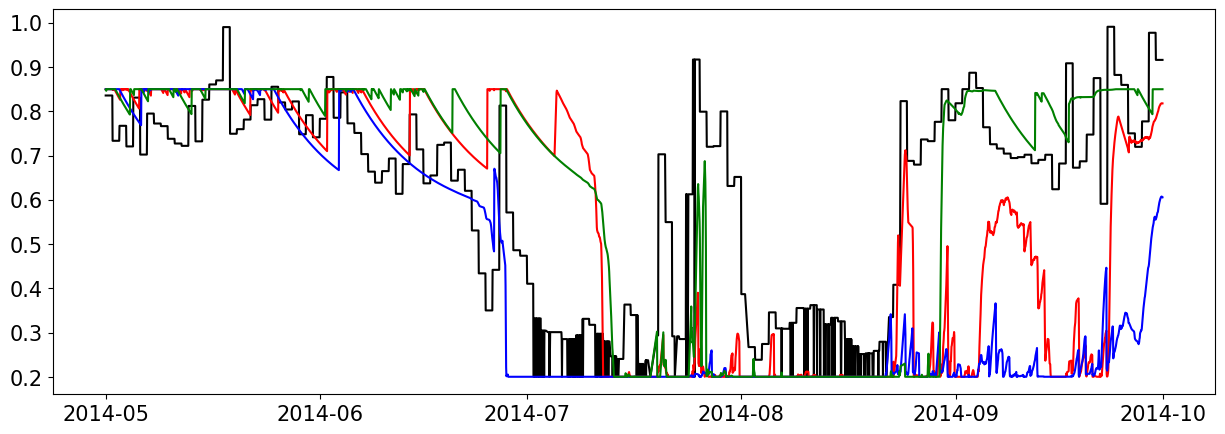

In [256]:
year = "2014"
fig = plt.figure(figsize=(15,5))

plt.plot(cosipy_36hmean_Eflux["albedo_obs"][year], color = "k")
plt.plot(cosipy_36hmean_Eflux["ALBEDO"][year], color = "r")
plt.plot(cosipy_108hmean_Eflux["ALBEDO"][year], color = "b")
plt.plot(cosipy_era5_Eflux["ALBEDO"][year], color = "green")

In [75]:
cosipy_36hmean_Eflux[energy_fluxes].groupby(cosipy_36hmean_Eflux["prob_jjmc_filter1"] >= 0.5).mean()

,G,G_out,LWin,LWout,H,LE,B,Q,ME
prob_jjmc_filter1,,,,,,,,,
False,158.156702,84.263676,268.188678,-295.382236,14.214574,0.006524,-0.700874,0.000551,48.714747
True,132.446248,83.337363,265.262953,-296.967618,49.714423,-10.489299,-4.161112,0.000464,45.280781


In [76]:
cosipy_36hmean_Eflux[energy_fluxes].groupby(cosipy_36hmean_Eflux["prob_jjmc_filter1"] < 0.5).mean()

,G,G_out,LWin,LWout,H,LE,B,Q,ME
prob_jjmc_filter1,,,,,,,,,
False,132.446248,83.337363,265.262953,-296.967618,49.714423,-10.489299,-4.161112,0.000464,45.280781
True,158.156702,84.263676,268.188678,-295.382236,14.214574,0.006524,-0.700874,0.000551,48.714747


In [63]:
cosipy_108hmean_Eflux[energy_fluxes].groupby(cosipy_108hmean_Eflux["prob_jjmc_filter1"] >= 0.5).mean()

,G,G_out,LWin,LWout,H,LE,B,Q,ME
prob_jjmc_filter1,,,,,,,,,
False,152.522263,67.771613,270.015013,-296.656412,13.810137,-0.591398,-0.960363,0.000666,56.456717
True,132.446248,71.757959,265.262953,-297.751133,51.651485,-13.240884,-4.100817,0.000555,53.041258


In [64]:
cosipy_era5_Eflux[energy_fluxes].groupby(cosipy_era5_Eflux["prob_jjmc_filter1"] >= 0.5).mean()

,G,G_out,LWin,LWout,H,LE,B,Q,ME
prob_jjmc_filter1,,,,,,,,,
False,152.522263,89.427118,270.015013,-294.388218,14.020842,0.642062,-0.555863,0.000521,43.578907
True,132.446248,94.543787,265.262953,-296.145491,47.838217,-7.849241,-3.245593,0.000376,38.784679


In [81]:
cosipy_36hmean_Eflux_foehn = cosipy_36hmean_Eflux.loc[cosipy_36hmean_Eflux["prob_jjmc_filter1"] >= 0.5]
cosipy_36hmean_Eflux_nofoehn = cosipy_36hmean_Eflux.loc[cosipy_36hmean_Eflux["prob_jjmc_filter1"] < 0.5]

In [84]:
cosipy_36hmean_Eflux_foehn[energy_fluxes].mean()

G        132.446248
G_out     83.337363
LWin     265.262953
LWout   -296.967618
H         49.714423
LE       -10.489299
B         -4.161112
Q          0.000464
ME        45.280781
dtype: float64

In [85]:
cosipy_36hmean_Eflux_nofoehn[energy_fluxes].mean()

G        158.156702
G_out     84.263676
LWin     268.188678
LWout   -295.382236
H         14.214574
LE         0.006524
B         -0.700874
Q          0.000551
ME        48.714747
dtype: float64

In [45]:
#compute monthly averages
test = cosipy_36hmean_Eflux.groupby(cosipy_36hmean_Eflux.time.dt.month).mean()
test["H"].values

array([14.07553817, 15.1539149 , 18.3004754 , 16.18509735, 11.79338856])

In [54]:
ind = foehn_data.index.intersection(cosipy_36hmean_Eflux.index)

In [56]:
len(foehn_data.loc[ind])

23111

In [72]:
import pandas as pd
import numpy as np

# Angenommen, Ihr DataFrame heißt df
# Beispiel-Daten
data = {
    'A': [1, 2, np.nan],
    'B': [np.nan, 2, 3]
}
df = pd.DataFrame(data)

# Entfernen aller Zeilen, in denen der Eintrag in Spalte "B" NaN ist
df_cleaned = df.dropna(subset=['B'])

print(df_cleaned)


     A    B
1  2.0  2.0
2  NaN  3.0
